In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,AdamW
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user = nn.Embedding(nb_users, mf_dim)
        self.mf_item = nn.Embedding(nb_items, mf_dim)

        size = mlp_layer_sizes[0] // 2
        self.mlp_user = nn.Embedding(nb_users, size)
        self.mlp_item = nn.Embedding(nb_items, size)

        self.dropout = dropout

        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])\
                                  for i in range(1,nb_mlp_layers)])
        self.last = nn.Linear(mlp_layer_sizes[-1]+mf_dim, 1)     
        

        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)

        #YOUR TASK: Initialze weights ~4 lines of code - use glorot (final MLP has to use lecunn

        self.mf_user.weight.data.normal_(0., 0.01)
        self.mf_item.weight.data.normal_(0., 0.01)
        self.mlp_user.weight.data.normal_(0., 0.01)
        self.mlp_item.weight.data.normal_(0., 0.01)

        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.last)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        mf_user =  self.mf_user(user)
        mf_item =  self.mf_item(item)
        mf = mf_user * mf_item

        mlp_user = self.mlp_user(user)
        mlp_item = self.mlp_item(item)
        mlp = torch.cat((mlp_user, mlp_item), dim=1)
        for i,layer in enumerate(self.mlp):
            mlp = layer(mlp)
            mlp = nn.functional.relu(mlp)
            if self.dropout != 0:
                mlp = nn.functional.dropout(mlp, p=self.dropout, training=self.training)

        x = torch.cat((mf,mlp), dim=1)
        x = self.last(x)
        if sigmoid:
            x = torch.sigmoid(x)

        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self, file_name, negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'], axis=1, inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this! store them in self.users,self.items,self.labels
        #Sample neg users
        user, item = 0, 1
        
        neg_users = ratings[:, user].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:, user], neg_users))
        #sample neg items
        
        neg_items = torch.empty_like(ratings[:,item])
        neg_items = neg_items.repeat(self.negative_samples)
        neg_items = neg_items.random_(0,max_item)
        self.items = torch.cat((ratings[:,item], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,item], dtype=torch.float32)
        neg_label = neg_label.repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,item], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [5]:
torch.cuda.is_available()

False

In [8]:
# Constants for the dataset and hyperparameters
num_users = 944
num_movies = 1683
cross_val_splits = 3
epochs = 40
batch_size = 16 * 1024
device = torch.device('cpu')

# Load the dataset
train_dataset = ML100kDataset('ml-100k/u1.base', 2)
test_dataset = ML100kDataset('ml-100k/u1.test', 2)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Split training data for cross-validation
dataset_len = len(train_dataset)
subset_lengths = [dataset_len // cross_val_splits] * cross_val_splits
subset_lengths[-1] += dataset_len % cross_val_splits
train_subsets = random_split(train_dataset, subset_lengths)

# Hyperparameters to tune
hyperparams = {
    'mf_dim': [4, 8, 16],
    'mlp_layer_sizes': [[64, 32], [128, 64, 32]],
    'learning_rate': [0.1, 0.001],
    'dropout': [0.3, 0.6],
}

# Calculate total iterations for progress tracking
total_iterations = 0
max_iterations = epochs * cross_val_splits
for param in hyperparams.values():
    max_iterations *= len(param)

# DataFrame to store results
results_df = pd.DataFrame()

# Training loop
for mf_dim in hyperparams['mf_dim']:
    for mlp_sizes in hyperparams['mlp_layer_sizes']:
        for lr in hyperparams['learning_rate']:
            for dropout in hyperparams['dropout']:
                cross_val_loss = []

                for fold in range(cross_val_splits):
                    train_loader = DataLoader(train_subsets[fold], batch_size=batch_size, shuffle=True)

                    model = NeuMF(num_users, num_movies, mf_dim, mlp_sizes, dropout).to(device)
                    loss_fn = nn.BCELoss()
                    optimizer = AdamW(model.parameters(), lr=lr)

                    epoch_train_loss = []
                    epoch_test_loss = []

                    for epoch in range(epochs):
                        model.train()
                        batch_train_loss = []

                        print(f"Epoch {epoch + 1} - Iteration {total_iterations + 1}/{max_iterations}")

                        for users, items, labels in tqdm.tqdm(train_loader):
                            users, items, labels = users.to(device), items.to(device), labels.to(device)

                            optimizer.zero_grad()
                            outputs = model(users, items, sigmoid=True)
                            labels = labels.unsqueeze(1)
                            loss = loss_fn(outputs, labels)
                            batch_train_loss.append(loss.item())
                            loss.backward()
                            optimizer.step()

                        epoch_train_loss.append(np.mean(batch_train_loss))

                        with torch.no_grad():
                            model.eval()
                            batch_test_loss = []
                            for users, items, labels in test_loader:
                                users, items, labels = users.to(device), items.to(device), labels.to(device)
                                outputs = model(users, items, sigmoid=True)
                                labels = labels.unsqueeze(1)
                                loss = loss_fn(outputs, labels)
                                batch_test_loss.append(loss.item())
                            epoch_test_loss.append(np.mean(batch_test_loss))

                        total_iterations += 1

                    cross_val_loss.append(epoch_test_loss)

                mean_cross_val_loss = np.mean(cross_val_loss)

                current_result = pd.DataFrame({
                    'mf_dim': [mf_dim],
                    'mlp_layer_sizes': [mlp_sizes],
                    'learning_rate': [lr],
                    'dropout': [dropout],
                    'loss': [mean_cross_val_loss],
                    'loss_ep': [{'train': epoch_train_loss, 'test': epoch_test_loss}]
                })

                results_df = pd.concat([results_df, current_result], ignore_index=True)

print(results_df)


Epoch 1 - Iteration 1/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.85it/s]


Epoch 2 - Iteration 2/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 3 - Iteration 3/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


Epoch 4 - Iteration 4/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.87it/s]


Epoch 5 - Iteration 5/2880


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 6 - Iteration 6/2880


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


Epoch 7 - Iteration 7/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.34it/s]


Epoch 8 - Iteration 8/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


Epoch 9 - Iteration 9/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 10 - Iteration 10/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.41it/s]


Epoch 11 - Iteration 11/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 12 - Iteration 12/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


Epoch 13 - Iteration 13/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 14 - Iteration 14/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 15 - Iteration 15/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


Epoch 16 - Iteration 16/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.73it/s]


Epoch 17 - Iteration 17/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 18 - Iteration 18/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 19 - Iteration 19/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 20 - Iteration 20/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 21 - Iteration 21/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.34it/s]


Epoch 22 - Iteration 22/2880


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


Epoch 23 - Iteration 23/2880


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


Epoch 24 - Iteration 24/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


Epoch 25 - Iteration 25/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


Epoch 26 - Iteration 26/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.89it/s]


Epoch 27 - Iteration 27/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 28 - Iteration 28/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 29 - Iteration 29/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 30 - Iteration 30/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 31 - Iteration 31/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 32 - Iteration 32/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 33 - Iteration 33/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 34 - Iteration 34/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 35 - Iteration 35/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 36 - Iteration 36/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 37 - Iteration 37/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 38 - Iteration 38/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 39 - Iteration 39/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 40 - Iteration 40/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 1 - Iteration 41/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 2 - Iteration 42/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 3 - Iteration 43/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 4 - Iteration 44/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 5 - Iteration 45/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 6 - Iteration 46/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 7 - Iteration 47/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 8 - Iteration 48/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


Epoch 9 - Iteration 49/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 10 - Iteration 50/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 11 - Iteration 51/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 12 - Iteration 52/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 13 - Iteration 53/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 14 - Iteration 54/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.88it/s]


Epoch 15 - Iteration 55/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 16 - Iteration 56/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 17 - Iteration 57/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 18 - Iteration 58/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 19 - Iteration 59/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 20 - Iteration 60/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 21 - Iteration 61/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 22 - Iteration 62/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 23 - Iteration 63/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 24 - Iteration 64/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]


Epoch 25 - Iteration 65/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 26 - Iteration 66/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 27 - Iteration 67/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 28 - Iteration 68/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 29 - Iteration 69/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 30 - Iteration 70/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 31 - Iteration 71/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 32 - Iteration 72/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 33 - Iteration 73/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 34 - Iteration 74/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 35 - Iteration 75/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 36 - Iteration 76/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 37 - Iteration 77/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 38 - Iteration 78/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 39 - Iteration 79/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 40 - Iteration 80/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 1 - Iteration 81/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 2 - Iteration 82/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 3 - Iteration 83/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 4 - Iteration 84/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 5 - Iteration 85/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 6 - Iteration 86/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 7 - Iteration 87/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 8 - Iteration 88/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 9 - Iteration 89/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 10 - Iteration 90/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 11 - Iteration 91/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 12 - Iteration 92/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 13 - Iteration 93/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 14 - Iteration 94/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 15 - Iteration 95/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 16 - Iteration 96/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 17 - Iteration 97/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 18 - Iteration 98/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 19 - Iteration 99/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 20 - Iteration 100/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 21 - Iteration 101/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 22 - Iteration 102/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 23 - Iteration 103/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 24 - Iteration 104/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 25 - Iteration 105/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 26 - Iteration 106/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 27 - Iteration 107/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 28 - Iteration 108/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 29 - Iteration 109/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]


Epoch 30 - Iteration 110/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 31 - Iteration 111/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch 32 - Iteration 112/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 33 - Iteration 113/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 34 - Iteration 114/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 35 - Iteration 115/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 36 - Iteration 116/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 37 - Iteration 117/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 38 - Iteration 118/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 39 - Iteration 119/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 40 - Iteration 120/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 1 - Iteration 121/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 2 - Iteration 122/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 3 - Iteration 123/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 4 - Iteration 124/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 5 - Iteration 125/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 6 - Iteration 126/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 7 - Iteration 127/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 8 - Iteration 128/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 9 - Iteration 129/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 10 - Iteration 130/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 11 - Iteration 131/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 12 - Iteration 132/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 13 - Iteration 133/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 14 - Iteration 134/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 15 - Iteration 135/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 16 - Iteration 136/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 17 - Iteration 137/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 18 - Iteration 138/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 19 - Iteration 139/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 20 - Iteration 140/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 21 - Iteration 141/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 22 - Iteration 142/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 23 - Iteration 143/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 24 - Iteration 144/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 25 - Iteration 145/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 26 - Iteration 146/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 27 - Iteration 147/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 28 - Iteration 148/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 29 - Iteration 149/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 30 - Iteration 150/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 31 - Iteration 151/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 32 - Iteration 152/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 33 - Iteration 153/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 34 - Iteration 154/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 35 - Iteration 155/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 36 - Iteration 156/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 37 - Iteration 157/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 38 - Iteration 158/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 39 - Iteration 159/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 40 - Iteration 160/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 1 - Iteration 161/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 2 - Iteration 162/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 3 - Iteration 163/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 4 - Iteration 164/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 5 - Iteration 165/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 6 - Iteration 166/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]


Epoch 7 - Iteration 167/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 8 - Iteration 168/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 9 - Iteration 169/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 10 - Iteration 170/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 11 - Iteration 171/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 12 - Iteration 172/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 13 - Iteration 173/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 14 - Iteration 174/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 15 - Iteration 175/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 16 - Iteration 176/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 17 - Iteration 177/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 18 - Iteration 178/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 19 - Iteration 179/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 20 - Iteration 180/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 21 - Iteration 181/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 22 - Iteration 182/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 23 - Iteration 183/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 24 - Iteration 184/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 25 - Iteration 185/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 26 - Iteration 186/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 27 - Iteration 187/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 28 - Iteration 188/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 29 - Iteration 189/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 30 - Iteration 190/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 31 - Iteration 191/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 32 - Iteration 192/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 33 - Iteration 193/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 34 - Iteration 194/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 35 - Iteration 195/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 36 - Iteration 196/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 37 - Iteration 197/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 38 - Iteration 198/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 39 - Iteration 199/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 40 - Iteration 200/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 1 - Iteration 201/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 2 - Iteration 202/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 3 - Iteration 203/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 4 - Iteration 204/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 5 - Iteration 205/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 6 - Iteration 206/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 7 - Iteration 207/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 8 - Iteration 208/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 9 - Iteration 209/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 10 - Iteration 210/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 11 - Iteration 211/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 12 - Iteration 212/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 13 - Iteration 213/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 14 - Iteration 214/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 15 - Iteration 215/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 16 - Iteration 216/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 17 - Iteration 217/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 18 - Iteration 218/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 19 - Iteration 219/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 20 - Iteration 220/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 21 - Iteration 221/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 22 - Iteration 222/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 23 - Iteration 223/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]


Epoch 24 - Iteration 224/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 25 - Iteration 225/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 26 - Iteration 226/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 27 - Iteration 227/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 28 - Iteration 228/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 29 - Iteration 229/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 30 - Iteration 230/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 31 - Iteration 231/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 32 - Iteration 232/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 33 - Iteration 233/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 34 - Iteration 234/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 35 - Iteration 235/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]


Epoch 36 - Iteration 236/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 37 - Iteration 237/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 38 - Iteration 238/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 39 - Iteration 239/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 40 - Iteration 240/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 1 - Iteration 241/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 2 - Iteration 242/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 3 - Iteration 243/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 4 - Iteration 244/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 5 - Iteration 245/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 6 - Iteration 246/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 7 - Iteration 247/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 8 - Iteration 248/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.87it/s]


Epoch 9 - Iteration 249/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 10 - Iteration 250/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 11 - Iteration 251/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 12 - Iteration 252/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 13 - Iteration 253/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 14 - Iteration 254/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 15 - Iteration 255/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 16 - Iteration 256/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 17 - Iteration 257/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 18 - Iteration 258/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 19 - Iteration 259/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 20 - Iteration 260/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 21 - Iteration 261/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 22 - Iteration 262/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 23 - Iteration 263/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 24 - Iteration 264/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 25 - Iteration 265/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 26 - Iteration 266/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 27 - Iteration 267/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 28 - Iteration 268/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 29 - Iteration 269/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 30 - Iteration 270/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 31 - Iteration 271/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 32 - Iteration 272/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 33 - Iteration 273/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 34 - Iteration 274/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 35 - Iteration 275/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 36 - Iteration 276/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 37 - Iteration 277/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 38 - Iteration 278/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 39 - Iteration 279/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 40 - Iteration 280/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 1 - Iteration 281/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 2 - Iteration 282/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 3 - Iteration 283/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 4 - Iteration 284/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 5 - Iteration 285/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 6 - Iteration 286/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 7 - Iteration 287/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 8 - Iteration 288/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.83it/s]


Epoch 9 - Iteration 289/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 10 - Iteration 290/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 11 - Iteration 291/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 12 - Iteration 292/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 13 - Iteration 293/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 14 - Iteration 294/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 15 - Iteration 295/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch 16 - Iteration 296/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 17 - Iteration 297/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 18 - Iteration 298/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.85it/s]


Epoch 19 - Iteration 299/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 20 - Iteration 300/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 21 - Iteration 301/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 22 - Iteration 302/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 23 - Iteration 303/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 24 - Iteration 304/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 25 - Iteration 305/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 26 - Iteration 306/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 27 - Iteration 307/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 28 - Iteration 308/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 29 - Iteration 309/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 30 - Iteration 310/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 31 - Iteration 311/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 32 - Iteration 312/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 33 - Iteration 313/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 34 - Iteration 314/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 35 - Iteration 315/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 36 - Iteration 316/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 37 - Iteration 317/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 38 - Iteration 318/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 39 - Iteration 319/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 40 - Iteration 320/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 1 - Iteration 321/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 2 - Iteration 322/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 3 - Iteration 323/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


Epoch 4 - Iteration 324/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 5 - Iteration 325/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 6 - Iteration 326/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 7 - Iteration 327/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 8 - Iteration 328/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 9 - Iteration 329/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 10 - Iteration 330/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 11 - Iteration 331/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 12 - Iteration 332/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 13 - Iteration 333/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 14 - Iteration 334/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 15 - Iteration 335/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 16 - Iteration 336/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 17 - Iteration 337/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 18 - Iteration 338/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]


Epoch 19 - Iteration 339/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 20 - Iteration 340/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 21 - Iteration 341/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 22 - Iteration 342/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 23 - Iteration 343/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 24 - Iteration 344/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 25 - Iteration 345/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 26 - Iteration 346/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 27 - Iteration 347/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 28 - Iteration 348/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 29 - Iteration 349/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 30 - Iteration 350/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 31 - Iteration 351/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 32 - Iteration 352/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 33 - Iteration 353/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 34 - Iteration 354/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 35 - Iteration 355/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 36 - Iteration 356/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 37 - Iteration 357/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 38 - Iteration 358/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 39 - Iteration 359/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 40 - Iteration 360/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 1 - Iteration 361/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 2 - Iteration 362/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 3 - Iteration 363/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 4 - Iteration 364/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 5 - Iteration 365/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 6 - Iteration 366/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 7 - Iteration 367/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


Epoch 8 - Iteration 368/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 9 - Iteration 369/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 10 - Iteration 370/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 11 - Iteration 371/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 12 - Iteration 372/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 13 - Iteration 373/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 14 - Iteration 374/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 15 - Iteration 375/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 16 - Iteration 376/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 17 - Iteration 377/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 18 - Iteration 378/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 19 - Iteration 379/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 20 - Iteration 380/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 21 - Iteration 381/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 22 - Iteration 382/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 23 - Iteration 383/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 24 - Iteration 384/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 25 - Iteration 385/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 26 - Iteration 386/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 27 - Iteration 387/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 28 - Iteration 388/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 29 - Iteration 389/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 30 - Iteration 390/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 31 - Iteration 391/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 32 - Iteration 392/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 33 - Iteration 393/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 34 - Iteration 394/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 35 - Iteration 395/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 36 - Iteration 396/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 37 - Iteration 397/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 38 - Iteration 398/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 39 - Iteration 399/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 40 - Iteration 400/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 1 - Iteration 401/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 2 - Iteration 402/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 3 - Iteration 403/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 4 - Iteration 404/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch 5 - Iteration 405/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 6 - Iteration 406/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 7 - Iteration 407/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 8 - Iteration 408/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 9 - Iteration 409/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 10 - Iteration 410/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 11 - Iteration 411/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 12 - Iteration 412/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 13 - Iteration 413/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 14 - Iteration 414/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 15 - Iteration 415/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 16 - Iteration 416/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 17 - Iteration 417/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 18 - Iteration 418/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 19 - Iteration 419/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 20 - Iteration 420/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.79it/s]


Epoch 21 - Iteration 421/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 22 - Iteration 422/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 23 - Iteration 423/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 24 - Iteration 424/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 25 - Iteration 425/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 26 - Iteration 426/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 27 - Iteration 427/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 28 - Iteration 428/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 29 - Iteration 429/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 30 - Iteration 430/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 31 - Iteration 431/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 32 - Iteration 432/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 33 - Iteration 433/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 34 - Iteration 434/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 35 - Iteration 435/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.99it/s]


Epoch 36 - Iteration 436/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 37 - Iteration 437/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 38 - Iteration 438/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 39 - Iteration 439/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 40 - Iteration 440/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 1 - Iteration 441/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 2 - Iteration 442/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 3 - Iteration 443/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 4 - Iteration 444/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 5 - Iteration 445/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 6 - Iteration 446/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 7 - Iteration 447/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 8 - Iteration 448/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 9 - Iteration 449/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 10 - Iteration 450/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 11 - Iteration 451/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 12 - Iteration 452/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 13 - Iteration 453/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 14 - Iteration 454/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 15 - Iteration 455/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 16 - Iteration 456/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 17 - Iteration 457/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 18 - Iteration 458/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 19 - Iteration 459/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 20 - Iteration 460/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 21 - Iteration 461/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 22 - Iteration 462/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 23 - Iteration 463/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 24 - Iteration 464/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 25 - Iteration 465/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 26 - Iteration 466/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 27 - Iteration 467/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 28 - Iteration 468/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 29 - Iteration 469/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 30 - Iteration 470/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 31 - Iteration 471/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 32 - Iteration 472/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 33 - Iteration 473/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 34 - Iteration 474/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 35 - Iteration 475/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 36 - Iteration 476/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 37 - Iteration 477/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 38 - Iteration 478/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 39 - Iteration 479/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 40 - Iteration 480/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 1 - Iteration 481/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 2 - Iteration 482/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 3 - Iteration 483/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 4 - Iteration 484/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 5 - Iteration 485/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 6 - Iteration 486/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 7 - Iteration 487/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]


Epoch 8 - Iteration 488/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 9 - Iteration 489/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 10 - Iteration 490/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 11 - Iteration 491/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 12 - Iteration 492/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 13 - Iteration 493/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 14 - Iteration 494/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 15 - Iteration 495/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 16 - Iteration 496/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 17 - Iteration 497/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 18 - Iteration 498/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 19 - Iteration 499/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 20 - Iteration 500/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 21 - Iteration 501/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 22 - Iteration 502/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 23 - Iteration 503/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 24 - Iteration 504/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 25 - Iteration 505/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 26 - Iteration 506/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 27 - Iteration 507/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 28 - Iteration 508/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 29 - Iteration 509/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 30 - Iteration 510/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 31 - Iteration 511/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 32 - Iteration 512/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.48it/s]


Epoch 33 - Iteration 513/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 34 - Iteration 514/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 35 - Iteration 515/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 36 - Iteration 516/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 37 - Iteration 517/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 38 - Iteration 518/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 39 - Iteration 519/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 40 - Iteration 520/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 1 - Iteration 521/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 2 - Iteration 522/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 3 - Iteration 523/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 4 - Iteration 524/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 5 - Iteration 525/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 6 - Iteration 526/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 7 - Iteration 527/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 8 - Iteration 528/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 9 - Iteration 529/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 10 - Iteration 530/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 11 - Iteration 531/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 12 - Iteration 532/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 13 - Iteration 533/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 14 - Iteration 534/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 15 - Iteration 535/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 16 - Iteration 536/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 17 - Iteration 537/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 18 - Iteration 538/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 19 - Iteration 539/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 20 - Iteration 540/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 21 - Iteration 541/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 22 - Iteration 542/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 23 - Iteration 543/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 24 - Iteration 544/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 25 - Iteration 545/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 26 - Iteration 546/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 27 - Iteration 547/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 28 - Iteration 548/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 29 - Iteration 549/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 30 - Iteration 550/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 31 - Iteration 551/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 32 - Iteration 552/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 33 - Iteration 553/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 34 - Iteration 554/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 35 - Iteration 555/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 36 - Iteration 556/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 37 - Iteration 557/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]


Epoch 38 - Iteration 558/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 39 - Iteration 559/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 40 - Iteration 560/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 1 - Iteration 561/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 2 - Iteration 562/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 3 - Iteration 563/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 4 - Iteration 564/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 5 - Iteration 565/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 6 - Iteration 566/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.74it/s]


Epoch 7 - Iteration 567/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 8 - Iteration 568/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 9 - Iteration 569/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 10 - Iteration 570/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 11 - Iteration 571/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 12 - Iteration 572/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 13 - Iteration 573/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 14 - Iteration 574/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 15 - Iteration 575/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 16 - Iteration 576/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 17 - Iteration 577/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 18 - Iteration 578/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.70it/s]


Epoch 19 - Iteration 579/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 20 - Iteration 580/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 21 - Iteration 581/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 22 - Iteration 582/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 23 - Iteration 583/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 24 - Iteration 584/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 25 - Iteration 585/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 26 - Iteration 586/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 27 - Iteration 587/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 28 - Iteration 588/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 29 - Iteration 589/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 30 - Iteration 590/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 31 - Iteration 591/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 32 - Iteration 592/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 33 - Iteration 593/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 34 - Iteration 594/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 35 - Iteration 595/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 36 - Iteration 596/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 37 - Iteration 597/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 38 - Iteration 598/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 39 - Iteration 599/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 40 - Iteration 600/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 1 - Iteration 601/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 2 - Iteration 602/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 3 - Iteration 603/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 4 - Iteration 604/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 5 - Iteration 605/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


Epoch 6 - Iteration 606/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 7 - Iteration 607/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 8 - Iteration 608/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 9 - Iteration 609/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 10 - Iteration 610/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 11 - Iteration 611/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.40it/s]


Epoch 12 - Iteration 612/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 13 - Iteration 613/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 14 - Iteration 614/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 15 - Iteration 615/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 16 - Iteration 616/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 17 - Iteration 617/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 18 - Iteration 618/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 19 - Iteration 619/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 20 - Iteration 620/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 21 - Iteration 621/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 22 - Iteration 622/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 23 - Iteration 623/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 24 - Iteration 624/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]


Epoch 25 - Iteration 625/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 26 - Iteration 626/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 27 - Iteration 627/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 28 - Iteration 628/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 29 - Iteration 629/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 30 - Iteration 630/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 31 - Iteration 631/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 32 - Iteration 632/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 33 - Iteration 633/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 34 - Iteration 634/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 35 - Iteration 635/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 36 - Iteration 636/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 37 - Iteration 637/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 38 - Iteration 638/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 39 - Iteration 639/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 40 - Iteration 640/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 1 - Iteration 641/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 2 - Iteration 642/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 3 - Iteration 643/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 4 - Iteration 644/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 5 - Iteration 645/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.72it/s]


Epoch 6 - Iteration 646/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 7 - Iteration 647/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 8 - Iteration 648/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 9 - Iteration 649/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 10 - Iteration 650/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 11 - Iteration 651/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]


Epoch 12 - Iteration 652/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 13 - Iteration 653/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 14 - Iteration 654/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 15 - Iteration 655/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 16 - Iteration 656/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 17 - Iteration 657/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 18 - Iteration 658/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 19 - Iteration 659/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 20 - Iteration 660/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 21 - Iteration 661/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 22 - Iteration 662/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 23 - Iteration 663/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 24 - Iteration 664/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 25 - Iteration 665/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 26 - Iteration 666/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 27 - Iteration 667/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.71it/s]


Epoch 28 - Iteration 668/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 29 - Iteration 669/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 30 - Iteration 670/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 31 - Iteration 671/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 32 - Iteration 672/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 33 - Iteration 673/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 34 - Iteration 674/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 35 - Iteration 675/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 36 - Iteration 676/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 37 - Iteration 677/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 38 - Iteration 678/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 39 - Iteration 679/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 40 - Iteration 680/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 1 - Iteration 681/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 2 - Iteration 682/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 3 - Iteration 683/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]


Epoch 4 - Iteration 684/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 5 - Iteration 685/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 6 - Iteration 686/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 7 - Iteration 687/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 8 - Iteration 688/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 9 - Iteration 689/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 10 - Iteration 690/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 11 - Iteration 691/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 12 - Iteration 692/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 13 - Iteration 693/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 14 - Iteration 694/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 15 - Iteration 695/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 16 - Iteration 696/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 17 - Iteration 697/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 18 - Iteration 698/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 19 - Iteration 699/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 20 - Iteration 700/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 21 - Iteration 701/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 22 - Iteration 702/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 23 - Iteration 703/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 24 - Iteration 704/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 25 - Iteration 705/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 26 - Iteration 706/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 27 - Iteration 707/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 28 - Iteration 708/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 29 - Iteration 709/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 30 - Iteration 710/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 31 - Iteration 711/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 32 - Iteration 712/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 33 - Iteration 713/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 34 - Iteration 714/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 35 - Iteration 715/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 36 - Iteration 716/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 37 - Iteration 717/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 38 - Iteration 718/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 39 - Iteration 719/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 40 - Iteration 720/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 1 - Iteration 721/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 2 - Iteration 722/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 3 - Iteration 723/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 4 - Iteration 724/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 5 - Iteration 725/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 6 - Iteration 726/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]


Epoch 7 - Iteration 727/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 8 - Iteration 728/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 9 - Iteration 729/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 10 - Iteration 730/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 11 - Iteration 731/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 12 - Iteration 732/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 13 - Iteration 733/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 14 - Iteration 734/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 15 - Iteration 735/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 16 - Iteration 736/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 17 - Iteration 737/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 18 - Iteration 738/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 19 - Iteration 739/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 20 - Iteration 740/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 21 - Iteration 741/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 22 - Iteration 742/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 23 - Iteration 743/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 24 - Iteration 744/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 25 - Iteration 745/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 26 - Iteration 746/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 27 - Iteration 747/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 28 - Iteration 748/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 29 - Iteration 749/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 30 - Iteration 750/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 31 - Iteration 751/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 32 - Iteration 752/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 33 - Iteration 753/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 34 - Iteration 754/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 35 - Iteration 755/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 36 - Iteration 756/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 37 - Iteration 757/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 38 - Iteration 758/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 39 - Iteration 759/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 40 - Iteration 760/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 1 - Iteration 761/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 2 - Iteration 762/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 3 - Iteration 763/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 4 - Iteration 764/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 5 - Iteration 765/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 6 - Iteration 766/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 7 - Iteration 767/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 8 - Iteration 768/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 9 - Iteration 769/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 10 - Iteration 770/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 11 - Iteration 771/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 12 - Iteration 772/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 13 - Iteration 773/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 14 - Iteration 774/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 15 - Iteration 775/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 16 - Iteration 776/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 17 - Iteration 777/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 18 - Iteration 778/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 19 - Iteration 779/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 20 - Iteration 780/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 21 - Iteration 781/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 22 - Iteration 782/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 23 - Iteration 783/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 24 - Iteration 784/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 25 - Iteration 785/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 26 - Iteration 786/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 27 - Iteration 787/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 28 - Iteration 788/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 29 - Iteration 789/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 30 - Iteration 790/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 31 - Iteration 791/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 32 - Iteration 792/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 33 - Iteration 793/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch 34 - Iteration 794/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 35 - Iteration 795/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 36 - Iteration 796/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 37 - Iteration 797/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 38 - Iteration 798/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 39 - Iteration 799/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 40 - Iteration 800/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 1 - Iteration 801/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 2 - Iteration 802/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 3 - Iteration 803/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 4 - Iteration 804/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 5 - Iteration 805/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 6 - Iteration 806/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 7 - Iteration 807/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 8 - Iteration 808/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 9 - Iteration 809/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 10 - Iteration 810/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 11 - Iteration 811/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 12 - Iteration 812/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 13 - Iteration 813/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 14 - Iteration 814/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 15 - Iteration 815/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 16 - Iteration 816/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 17 - Iteration 817/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 18 - Iteration 818/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 19 - Iteration 819/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 20 - Iteration 820/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 21 - Iteration 821/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 22 - Iteration 822/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 23 - Iteration 823/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 24 - Iteration 824/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 25 - Iteration 825/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 26 - Iteration 826/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 27 - Iteration 827/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 28 - Iteration 828/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 29 - Iteration 829/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 30 - Iteration 830/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 31 - Iteration 831/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 32 - Iteration 832/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 33 - Iteration 833/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 34 - Iteration 834/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 35 - Iteration 835/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]


Epoch 36 - Iteration 836/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 37 - Iteration 837/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 38 - Iteration 838/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 39 - Iteration 839/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 40 - Iteration 840/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 1 - Iteration 841/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 2 - Iteration 842/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 3 - Iteration 843/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 4 - Iteration 844/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 5 - Iteration 845/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 6 - Iteration 846/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 7 - Iteration 847/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 8 - Iteration 848/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 9 - Iteration 849/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 10 - Iteration 850/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 11 - Iteration 851/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 12 - Iteration 852/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 13 - Iteration 853/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 14 - Iteration 854/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 15 - Iteration 855/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 16 - Iteration 856/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 17 - Iteration 857/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 18 - Iteration 858/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 19 - Iteration 859/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 20 - Iteration 860/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 21 - Iteration 861/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 22 - Iteration 862/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 23 - Iteration 863/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 24 - Iteration 864/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 25 - Iteration 865/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 26 - Iteration 866/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 27 - Iteration 867/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.71it/s]


Epoch 28 - Iteration 868/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 29 - Iteration 869/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 30 - Iteration 870/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 31 - Iteration 871/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 32 - Iteration 872/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 33 - Iteration 873/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 34 - Iteration 874/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 35 - Iteration 875/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 36 - Iteration 876/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 37 - Iteration 877/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]


Epoch 38 - Iteration 878/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 39 - Iteration 879/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 40 - Iteration 880/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 1 - Iteration 881/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 2 - Iteration 882/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 3 - Iteration 883/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 4 - Iteration 884/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch 5 - Iteration 885/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 6 - Iteration 886/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 7 - Iteration 887/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 8 - Iteration 888/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 9 - Iteration 889/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 10 - Iteration 890/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 11 - Iteration 891/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 12 - Iteration 892/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch 13 - Iteration 893/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 14 - Iteration 894/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 15 - Iteration 895/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 16 - Iteration 896/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 17 - Iteration 897/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 18 - Iteration 898/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 19 - Iteration 899/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 20 - Iteration 900/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 21 - Iteration 901/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 22 - Iteration 902/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 23 - Iteration 903/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 24 - Iteration 904/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 25 - Iteration 905/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 26 - Iteration 906/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 27 - Iteration 907/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 28 - Iteration 908/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 29 - Iteration 909/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 30 - Iteration 910/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 31 - Iteration 911/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 32 - Iteration 912/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 33 - Iteration 913/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 34 - Iteration 914/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 35 - Iteration 915/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 36 - Iteration 916/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 37 - Iteration 917/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 38 - Iteration 918/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 39 - Iteration 919/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 40 - Iteration 920/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 1 - Iteration 921/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 2 - Iteration 922/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 3 - Iteration 923/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 4 - Iteration 924/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 5 - Iteration 925/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 6 - Iteration 926/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 7 - Iteration 927/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 8 - Iteration 928/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 9 - Iteration 929/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 10 - Iteration 930/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 11 - Iteration 931/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 12 - Iteration 932/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 13 - Iteration 933/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 14 - Iteration 934/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 15 - Iteration 935/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.69it/s]


Epoch 16 - Iteration 936/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 17 - Iteration 937/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 18 - Iteration 938/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 19 - Iteration 939/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 20 - Iteration 940/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 21 - Iteration 941/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 22 - Iteration 942/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 23 - Iteration 943/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 24 - Iteration 944/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 25 - Iteration 945/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 26 - Iteration 946/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 27 - Iteration 947/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 28 - Iteration 948/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 29 - Iteration 949/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 30 - Iteration 950/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 31 - Iteration 951/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch 32 - Iteration 952/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 33 - Iteration 953/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 34 - Iteration 954/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 35 - Iteration 955/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 36 - Iteration 956/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 37 - Iteration 957/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 38 - Iteration 958/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 39 - Iteration 959/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 40 - Iteration 960/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 1 - Iteration 961/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 2 - Iteration 962/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 3 - Iteration 963/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 4 - Iteration 964/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 5 - Iteration 965/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 6 - Iteration 966/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]


Epoch 7 - Iteration 967/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 8 - Iteration 968/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 9 - Iteration 969/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 10 - Iteration 970/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 11 - Iteration 971/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 12 - Iteration 972/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 13 - Iteration 973/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 14 - Iteration 974/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 15 - Iteration 975/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 16 - Iteration 976/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 17 - Iteration 977/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 18 - Iteration 978/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 19 - Iteration 979/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.72it/s]


Epoch 20 - Iteration 980/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 21 - Iteration 981/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 22 - Iteration 982/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 23 - Iteration 983/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 24 - Iteration 984/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 25 - Iteration 985/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 26 - Iteration 986/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 27 - Iteration 987/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 28 - Iteration 988/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 29 - Iteration 989/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 30 - Iteration 990/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 31 - Iteration 991/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 32 - Iteration 992/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 33 - Iteration 993/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 34 - Iteration 994/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 35 - Iteration 995/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 36 - Iteration 996/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 37 - Iteration 997/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 38 - Iteration 998/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]


Epoch 39 - Iteration 999/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 40 - Iteration 1000/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


Epoch 1 - Iteration 1001/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 2 - Iteration 1002/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 3 - Iteration 1003/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 4 - Iteration 1004/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 5 - Iteration 1005/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 6 - Iteration 1006/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 7 - Iteration 1007/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 8 - Iteration 1008/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 9 - Iteration 1009/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 10 - Iteration 1010/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 11 - Iteration 1011/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 12 - Iteration 1012/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 13 - Iteration 1013/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 14 - Iteration 1014/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 15 - Iteration 1015/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 16 - Iteration 1016/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 17 - Iteration 1017/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 18 - Iteration 1018/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 19 - Iteration 1019/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 20 - Iteration 1020/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 21 - Iteration 1021/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 22 - Iteration 1022/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 23 - Iteration 1023/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 24 - Iteration 1024/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 25 - Iteration 1025/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 26 - Iteration 1026/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 27 - Iteration 1027/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 28 - Iteration 1028/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 29 - Iteration 1029/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 30 - Iteration 1030/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 31 - Iteration 1031/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 32 - Iteration 1032/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 33 - Iteration 1033/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 34 - Iteration 1034/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 35 - Iteration 1035/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 36 - Iteration 1036/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 37 - Iteration 1037/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 38 - Iteration 1038/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 39 - Iteration 1039/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 40 - Iteration 1040/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 1 - Iteration 1041/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 2 - Iteration 1042/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 3 - Iteration 1043/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 4 - Iteration 1044/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


Epoch 5 - Iteration 1045/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 6 - Iteration 1046/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 7 - Iteration 1047/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 8 - Iteration 1048/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 9 - Iteration 1049/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 10 - Iteration 1050/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 11 - Iteration 1051/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 12 - Iteration 1052/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 13 - Iteration 1053/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 14 - Iteration 1054/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.96it/s]


Epoch 15 - Iteration 1055/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 16 - Iteration 1056/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 17 - Iteration 1057/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 18 - Iteration 1058/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 19 - Iteration 1059/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 20 - Iteration 1060/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 21 - Iteration 1061/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 22 - Iteration 1062/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 23 - Iteration 1063/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 24 - Iteration 1064/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 25 - Iteration 1065/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 26 - Iteration 1066/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 27 - Iteration 1067/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 28 - Iteration 1068/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 29 - Iteration 1069/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 30 - Iteration 1070/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 31 - Iteration 1071/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 32 - Iteration 1072/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 33 - Iteration 1073/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 34 - Iteration 1074/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 35 - Iteration 1075/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 36 - Iteration 1076/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 37 - Iteration 1077/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 38 - Iteration 1078/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 39 - Iteration 1079/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 40 - Iteration 1080/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 1 - Iteration 1081/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 2 - Iteration 1082/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 3 - Iteration 1083/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 4 - Iteration 1084/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 5 - Iteration 1085/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 6 - Iteration 1086/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 7 - Iteration 1087/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 8 - Iteration 1088/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 9 - Iteration 1089/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 10 - Iteration 1090/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 11 - Iteration 1091/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 12 - Iteration 1092/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 13 - Iteration 1093/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 14 - Iteration 1094/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 15 - Iteration 1095/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 16 - Iteration 1096/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 17 - Iteration 1097/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 18 - Iteration 1098/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 19 - Iteration 1099/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 20 - Iteration 1100/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 21 - Iteration 1101/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 22 - Iteration 1102/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 23 - Iteration 1103/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 24 - Iteration 1104/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 25 - Iteration 1105/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 26 - Iteration 1106/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 27 - Iteration 1107/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 28 - Iteration 1108/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 29 - Iteration 1109/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 30 - Iteration 1110/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 31 - Iteration 1111/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 32 - Iteration 1112/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 33 - Iteration 1113/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 34 - Iteration 1114/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 35 - Iteration 1115/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 36 - Iteration 1116/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 37 - Iteration 1117/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 38 - Iteration 1118/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 39 - Iteration 1119/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 40 - Iteration 1120/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 1 - Iteration 1121/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 2 - Iteration 1122/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 3 - Iteration 1123/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 4 - Iteration 1124/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 5 - Iteration 1125/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]


Epoch 6 - Iteration 1126/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 7 - Iteration 1127/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 8 - Iteration 1128/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.93it/s]


Epoch 9 - Iteration 1129/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 10 - Iteration 1130/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 11 - Iteration 1131/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 12 - Iteration 1132/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 13 - Iteration 1133/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 14 - Iteration 1134/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 15 - Iteration 1135/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 16 - Iteration 1136/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 17 - Iteration 1137/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 18 - Iteration 1138/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 19 - Iteration 1139/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 20 - Iteration 1140/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 21 - Iteration 1141/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 22 - Iteration 1142/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 23 - Iteration 1143/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 24 - Iteration 1144/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 25 - Iteration 1145/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 26 - Iteration 1146/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 27 - Iteration 1147/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 28 - Iteration 1148/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 29 - Iteration 1149/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 30 - Iteration 1150/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 31 - Iteration 1151/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 32 - Iteration 1152/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 33 - Iteration 1153/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 34 - Iteration 1154/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 35 - Iteration 1155/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 36 - Iteration 1156/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 37 - Iteration 1157/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 38 - Iteration 1158/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 39 - Iteration 1159/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]


Epoch 40 - Iteration 1160/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 1 - Iteration 1161/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 2 - Iteration 1162/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 3 - Iteration 1163/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 4 - Iteration 1164/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 5 - Iteration 1165/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 6 - Iteration 1166/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 7 - Iteration 1167/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.73it/s]


Epoch 8 - Iteration 1168/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 9 - Iteration 1169/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 10 - Iteration 1170/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 11 - Iteration 1171/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 12 - Iteration 1172/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 13 - Iteration 1173/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 14 - Iteration 1174/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 15 - Iteration 1175/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.77it/s]


Epoch 16 - Iteration 1176/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 17 - Iteration 1177/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 18 - Iteration 1178/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 19 - Iteration 1179/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 20 - Iteration 1180/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 21 - Iteration 1181/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 22 - Iteration 1182/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 23 - Iteration 1183/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 24 - Iteration 1184/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 25 - Iteration 1185/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 26 - Iteration 1186/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 27 - Iteration 1187/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 28 - Iteration 1188/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 29 - Iteration 1189/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 30 - Iteration 1190/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 31 - Iteration 1191/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 32 - Iteration 1192/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 33 - Iteration 1193/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 34 - Iteration 1194/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 35 - Iteration 1195/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 36 - Iteration 1196/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 37 - Iteration 1197/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]


Epoch 38 - Iteration 1198/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 39 - Iteration 1199/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 40 - Iteration 1200/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 1 - Iteration 1201/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 2 - Iteration 1202/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 3 - Iteration 1203/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 4 - Iteration 1204/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 5 - Iteration 1205/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 6 - Iteration 1206/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 7 - Iteration 1207/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 8 - Iteration 1208/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 9 - Iteration 1209/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 10 - Iteration 1210/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 11 - Iteration 1211/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 12 - Iteration 1212/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 13 - Iteration 1213/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 14 - Iteration 1214/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 15 - Iteration 1215/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 16 - Iteration 1216/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 17 - Iteration 1217/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 18 - Iteration 1218/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 19 - Iteration 1219/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 20 - Iteration 1220/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 21 - Iteration 1221/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 22 - Iteration 1222/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 23 - Iteration 1223/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 24 - Iteration 1224/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 25 - Iteration 1225/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 26 - Iteration 1226/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 27 - Iteration 1227/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 28 - Iteration 1228/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 29 - Iteration 1229/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 30 - Iteration 1230/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 31 - Iteration 1231/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 32 - Iteration 1232/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 33 - Iteration 1233/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 34 - Iteration 1234/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 35 - Iteration 1235/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 36 - Iteration 1236/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 37 - Iteration 1237/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 38 - Iteration 1238/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 39 - Iteration 1239/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 40 - Iteration 1240/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 1 - Iteration 1241/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 2 - Iteration 1242/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 3 - Iteration 1243/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 4 - Iteration 1244/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 5 - Iteration 1245/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 6 - Iteration 1246/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 7 - Iteration 1247/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 8 - Iteration 1248/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 9 - Iteration 1249/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 10 - Iteration 1250/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 11 - Iteration 1251/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 12 - Iteration 1252/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 13 - Iteration 1253/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 14 - Iteration 1254/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 15 - Iteration 1255/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 16 - Iteration 1256/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 17 - Iteration 1257/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 18 - Iteration 1258/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 19 - Iteration 1259/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch 20 - Iteration 1260/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 21 - Iteration 1261/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 22 - Iteration 1262/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 23 - Iteration 1263/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 24 - Iteration 1264/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 25 - Iteration 1265/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 26 - Iteration 1266/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 27 - Iteration 1267/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 28 - Iteration 1268/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 29 - Iteration 1269/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 30 - Iteration 1270/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 31 - Iteration 1271/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 32 - Iteration 1272/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 33 - Iteration 1273/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 34 - Iteration 1274/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 35 - Iteration 1275/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 36 - Iteration 1276/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 37 - Iteration 1277/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 38 - Iteration 1278/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 39 - Iteration 1279/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 40 - Iteration 1280/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 1 - Iteration 1281/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 2 - Iteration 1282/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 3 - Iteration 1283/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch 4 - Iteration 1284/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 5 - Iteration 1285/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 6 - Iteration 1286/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 7 - Iteration 1287/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.71it/s]


Epoch 8 - Iteration 1288/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 9 - Iteration 1289/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 10 - Iteration 1290/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 11 - Iteration 1291/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 12 - Iteration 1292/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 13 - Iteration 1293/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 14 - Iteration 1294/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 15 - Iteration 1295/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 16 - Iteration 1296/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 17 - Iteration 1297/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 18 - Iteration 1298/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 19 - Iteration 1299/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 20 - Iteration 1300/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 21 - Iteration 1301/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 22 - Iteration 1302/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 23 - Iteration 1303/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 24 - Iteration 1304/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 25 - Iteration 1305/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 26 - Iteration 1306/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 27 - Iteration 1307/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 28 - Iteration 1308/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 29 - Iteration 1309/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 30 - Iteration 1310/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 31 - Iteration 1311/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 32 - Iteration 1312/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 33 - Iteration 1313/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 34 - Iteration 1314/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 35 - Iteration 1315/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 36 - Iteration 1316/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 37 - Iteration 1317/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 38 - Iteration 1318/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 39 - Iteration 1319/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 40 - Iteration 1320/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 1 - Iteration 1321/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 2 - Iteration 1322/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 3 - Iteration 1323/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 4 - Iteration 1324/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 5 - Iteration 1325/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 6 - Iteration 1326/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 7 - Iteration 1327/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 8 - Iteration 1328/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 9 - Iteration 1329/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 10 - Iteration 1330/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 11 - Iteration 1331/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 12 - Iteration 1332/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 13 - Iteration 1333/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 14 - Iteration 1334/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 15 - Iteration 1335/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 16 - Iteration 1336/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.77it/s]


Epoch 17 - Iteration 1337/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 18 - Iteration 1338/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 19 - Iteration 1339/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 20 - Iteration 1340/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 21 - Iteration 1341/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 22 - Iteration 1342/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 23 - Iteration 1343/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 24 - Iteration 1344/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 25 - Iteration 1345/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 26 - Iteration 1346/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 27 - Iteration 1347/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 28 - Iteration 1348/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 29 - Iteration 1349/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 30 - Iteration 1350/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 31 - Iteration 1351/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 32 - Iteration 1352/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 33 - Iteration 1353/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 34 - Iteration 1354/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 35 - Iteration 1355/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 36 - Iteration 1356/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 37 - Iteration 1357/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.92it/s]


Epoch 38 - Iteration 1358/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 39 - Iteration 1359/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 40 - Iteration 1360/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 1 - Iteration 1361/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 2 - Iteration 1362/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 3 - Iteration 1363/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 4 - Iteration 1364/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 5 - Iteration 1365/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 6 - Iteration 1366/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 7 - Iteration 1367/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.91it/s]


Epoch 8 - Iteration 1368/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 9 - Iteration 1369/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 10 - Iteration 1370/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 11 - Iteration 1371/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 12 - Iteration 1372/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 13 - Iteration 1373/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 14 - Iteration 1374/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 15 - Iteration 1375/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 16 - Iteration 1376/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 17 - Iteration 1377/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 18 - Iteration 1378/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 19 - Iteration 1379/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 20 - Iteration 1380/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 21 - Iteration 1381/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 22 - Iteration 1382/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 23 - Iteration 1383/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 24 - Iteration 1384/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 25 - Iteration 1385/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 26 - Iteration 1386/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 27 - Iteration 1387/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 28 - Iteration 1388/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 29 - Iteration 1389/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 30 - Iteration 1390/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 31 - Iteration 1391/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 32 - Iteration 1392/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 33 - Iteration 1393/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 34 - Iteration 1394/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 35 - Iteration 1395/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 36 - Iteration 1396/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 37 - Iteration 1397/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 38 - Iteration 1398/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 39 - Iteration 1399/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 40 - Iteration 1400/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 1 - Iteration 1401/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 2 - Iteration 1402/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 3 - Iteration 1403/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 4 - Iteration 1404/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 5 - Iteration 1405/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]


Epoch 6 - Iteration 1406/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 7 - Iteration 1407/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 8 - Iteration 1408/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.81it/s]


Epoch 9 - Iteration 1409/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 10 - Iteration 1410/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 11 - Iteration 1411/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 12 - Iteration 1412/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 13 - Iteration 1413/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 14 - Iteration 1414/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 15 - Iteration 1415/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 16 - Iteration 1416/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 17 - Iteration 1417/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 18 - Iteration 1418/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 19 - Iteration 1419/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 20 - Iteration 1420/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 21 - Iteration 1421/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 22 - Iteration 1422/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 23 - Iteration 1423/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 24 - Iteration 1424/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 25 - Iteration 1425/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 26 - Iteration 1426/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 27 - Iteration 1427/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 28 - Iteration 1428/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 29 - Iteration 1429/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 30 - Iteration 1430/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 31 - Iteration 1431/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 32 - Iteration 1432/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 33 - Iteration 1433/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 34 - Iteration 1434/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 35 - Iteration 1435/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 36 - Iteration 1436/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 37 - Iteration 1437/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.34it/s]


Epoch 38 - Iteration 1438/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


Epoch 39 - Iteration 1439/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 40 - Iteration 1440/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 1 - Iteration 1441/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 2 - Iteration 1442/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 3 - Iteration 1443/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 4 - Iteration 1444/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 5 - Iteration 1445/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.37it/s]


Epoch 6 - Iteration 1446/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 7 - Iteration 1447/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 8 - Iteration 1448/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 9 - Iteration 1449/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.35it/s]


Epoch 10 - Iteration 1450/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 11 - Iteration 1451/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.50it/s]


Epoch 12 - Iteration 1452/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 13 - Iteration 1453/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 14 - Iteration 1454/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 15 - Iteration 1455/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 16 - Iteration 1456/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 17 - Iteration 1457/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 18 - Iteration 1458/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 19 - Iteration 1459/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 20 - Iteration 1460/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.51it/s]


Epoch 21 - Iteration 1461/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 22 - Iteration 1462/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 23 - Iteration 1463/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 24 - Iteration 1464/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 25 - Iteration 1465/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 26 - Iteration 1466/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 27 - Iteration 1467/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 28 - Iteration 1468/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 29 - Iteration 1469/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 30 - Iteration 1470/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 31 - Iteration 1471/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 32 - Iteration 1472/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 33 - Iteration 1473/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 34 - Iteration 1474/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


Epoch 35 - Iteration 1475/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.52it/s]


Epoch 36 - Iteration 1476/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 37 - Iteration 1477/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 38 - Iteration 1478/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 39 - Iteration 1479/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 40 - Iteration 1480/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 1 - Iteration 1481/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 2 - Iteration 1482/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 3 - Iteration 1483/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 4 - Iteration 1484/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 5 - Iteration 1485/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 6 - Iteration 1486/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 7 - Iteration 1487/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 8 - Iteration 1488/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 9 - Iteration 1489/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 10 - Iteration 1490/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 11 - Iteration 1491/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 12 - Iteration 1492/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 13 - Iteration 1493/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 14 - Iteration 1494/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 15 - Iteration 1495/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 16 - Iteration 1496/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 17 - Iteration 1497/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 18 - Iteration 1498/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 19 - Iteration 1499/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 20 - Iteration 1500/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 21 - Iteration 1501/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 22 - Iteration 1502/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 23 - Iteration 1503/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.48it/s]


Epoch 24 - Iteration 1504/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 25 - Iteration 1505/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 26 - Iteration 1506/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 27 - Iteration 1507/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 28 - Iteration 1508/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 29 - Iteration 1509/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 30 - Iteration 1510/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 31 - Iteration 1511/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch 32 - Iteration 1512/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.52it/s]


Epoch 33 - Iteration 1513/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 34 - Iteration 1514/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 35 - Iteration 1515/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 36 - Iteration 1516/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 37 - Iteration 1517/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 38 - Iteration 1518/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 39 - Iteration 1519/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.35it/s]


Epoch 40 - Iteration 1520/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 1 - Iteration 1521/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 2 - Iteration 1522/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 3 - Iteration 1523/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 4 - Iteration 1524/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 5 - Iteration 1525/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.47it/s]


Epoch 6 - Iteration 1526/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 7 - Iteration 1527/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 8 - Iteration 1528/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 9 - Iteration 1529/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 10 - Iteration 1530/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 11 - Iteration 1531/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 12 - Iteration 1532/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 13 - Iteration 1533/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 14 - Iteration 1534/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 15 - Iteration 1535/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.40it/s]


Epoch 16 - Iteration 1536/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 17 - Iteration 1537/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 18 - Iteration 1538/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 19 - Iteration 1539/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 20 - Iteration 1540/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 21 - Iteration 1541/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 22 - Iteration 1542/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch 23 - Iteration 1543/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 24 - Iteration 1544/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 25 - Iteration 1545/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 26 - Iteration 1546/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 27 - Iteration 1547/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 28 - Iteration 1548/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 29 - Iteration 1549/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.36it/s]


Epoch 30 - Iteration 1550/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 31 - Iteration 1551/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 32 - Iteration 1552/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 33 - Iteration 1553/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 34 - Iteration 1554/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 35 - Iteration 1555/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 36 - Iteration 1556/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 37 - Iteration 1557/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 38 - Iteration 1558/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 39 - Iteration 1559/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 40 - Iteration 1560/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 1 - Iteration 1561/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 2 - Iteration 1562/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 3 - Iteration 1563/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 4 - Iteration 1564/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 5 - Iteration 1565/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 6 - Iteration 1566/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 7 - Iteration 1567/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 8 - Iteration 1568/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.48it/s]


Epoch 9 - Iteration 1569/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 10 - Iteration 1570/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 11 - Iteration 1571/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 12 - Iteration 1572/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 13 - Iteration 1573/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 14 - Iteration 1574/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 15 - Iteration 1575/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 16 - Iteration 1576/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 17 - Iteration 1577/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 18 - Iteration 1578/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 19 - Iteration 1579/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.36it/s]


Epoch 20 - Iteration 1580/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch 21 - Iteration 1581/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 22 - Iteration 1582/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 23 - Iteration 1583/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.48it/s]


Epoch 24 - Iteration 1584/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 25 - Iteration 1585/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 26 - Iteration 1586/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 27 - Iteration 1587/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 28 - Iteration 1588/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 29 - Iteration 1589/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 30 - Iteration 1590/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 31 - Iteration 1591/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.37it/s]


Epoch 32 - Iteration 1592/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 33 - Iteration 1593/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 34 - Iteration 1594/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 35 - Iteration 1595/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 36 - Iteration 1596/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 37 - Iteration 1597/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 38 - Iteration 1598/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 39 - Iteration 1599/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 40 - Iteration 1600/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 1 - Iteration 1601/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 2 - Iteration 1602/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 3 - Iteration 1603/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 4 - Iteration 1604/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


Epoch 5 - Iteration 1605/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 6 - Iteration 1606/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 7 - Iteration 1607/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


Epoch 8 - Iteration 1608/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Epoch 9 - Iteration 1609/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 10 - Iteration 1610/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 11 - Iteration 1611/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 12 - Iteration 1612/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 13 - Iteration 1613/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 14 - Iteration 1614/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 15 - Iteration 1615/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch 16 - Iteration 1616/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


Epoch 17 - Iteration 1617/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 18 - Iteration 1618/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.33it/s]


Epoch 19 - Iteration 1619/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.34it/s]


Epoch 20 - Iteration 1620/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 21 - Iteration 1621/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch 22 - Iteration 1622/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 23 - Iteration 1623/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 24 - Iteration 1624/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 25 - Iteration 1625/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 26 - Iteration 1626/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 27 - Iteration 1627/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 28 - Iteration 1628/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


Epoch 29 - Iteration 1629/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.12it/s]


Epoch 30 - Iteration 1630/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 31 - Iteration 1631/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 32 - Iteration 1632/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 33 - Iteration 1633/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 34 - Iteration 1634/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 35 - Iteration 1635/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 36 - Iteration 1636/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.86it/s]


Epoch 37 - Iteration 1637/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.52it/s]


Epoch 38 - Iteration 1638/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 39 - Iteration 1639/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 40 - Iteration 1640/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 1 - Iteration 1641/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 2 - Iteration 1642/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 3 - Iteration 1643/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 4 - Iteration 1644/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 5 - Iteration 1645/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 6 - Iteration 1646/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 7 - Iteration 1647/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 8 - Iteration 1648/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 9 - Iteration 1649/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 10 - Iteration 1650/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 11 - Iteration 1651/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.38it/s]


Epoch 12 - Iteration 1652/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 13 - Iteration 1653/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 14 - Iteration 1654/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 15 - Iteration 1655/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.52it/s]


Epoch 16 - Iteration 1656/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 17 - Iteration 1657/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.39it/s]


Epoch 18 - Iteration 1658/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.51it/s]


Epoch 19 - Iteration 1659/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 20 - Iteration 1660/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 21 - Iteration 1661/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 22 - Iteration 1662/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 23 - Iteration 1663/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


Epoch 24 - Iteration 1664/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 25 - Iteration 1665/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 26 - Iteration 1666/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 27 - Iteration 1667/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 28 - Iteration 1668/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 29 - Iteration 1669/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 30 - Iteration 1670/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 31 - Iteration 1671/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 32 - Iteration 1672/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 33 - Iteration 1673/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 34 - Iteration 1674/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 35 - Iteration 1675/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 36 - Iteration 1676/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 37 - Iteration 1677/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 38 - Iteration 1678/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 39 - Iteration 1679/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 40 - Iteration 1680/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 1 - Iteration 1681/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 2 - Iteration 1682/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 3 - Iteration 1683/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 4 - Iteration 1684/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 5 - Iteration 1685/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 6 - Iteration 1686/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 7 - Iteration 1687/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 8 - Iteration 1688/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 9 - Iteration 1689/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 10 - Iteration 1690/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 11 - Iteration 1691/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 12 - Iteration 1692/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 13 - Iteration 1693/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 14 - Iteration 1694/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 15 - Iteration 1695/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 16 - Iteration 1696/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 17 - Iteration 1697/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 18 - Iteration 1698/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 19 - Iteration 1699/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 20 - Iteration 1700/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 21 - Iteration 1701/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 22 - Iteration 1702/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 23 - Iteration 1703/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 24 - Iteration 1704/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 25 - Iteration 1705/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 26 - Iteration 1706/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 27 - Iteration 1707/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 28 - Iteration 1708/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 29 - Iteration 1709/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 30 - Iteration 1710/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 31 - Iteration 1711/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 32 - Iteration 1712/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 33 - Iteration 1713/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 34 - Iteration 1714/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 35 - Iteration 1715/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 36 - Iteration 1716/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 37 - Iteration 1717/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 38 - Iteration 1718/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 39 - Iteration 1719/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 40 - Iteration 1720/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 1 - Iteration 1721/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 2 - Iteration 1722/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 3 - Iteration 1723/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 4 - Iteration 1724/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 5 - Iteration 1725/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 6 - Iteration 1726/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 7 - Iteration 1727/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 8 - Iteration 1728/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 9 - Iteration 1729/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 10 - Iteration 1730/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 11 - Iteration 1731/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 12 - Iteration 1732/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 13 - Iteration 1733/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 14 - Iteration 1734/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 15 - Iteration 1735/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 16 - Iteration 1736/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 17 - Iteration 1737/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 18 - Iteration 1738/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 19 - Iteration 1739/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 20 - Iteration 1740/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 21 - Iteration 1741/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 22 - Iteration 1742/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 23 - Iteration 1743/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 24 - Iteration 1744/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 25 - Iteration 1745/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 26 - Iteration 1746/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 27 - Iteration 1747/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 28 - Iteration 1748/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 29 - Iteration 1749/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 30 - Iteration 1750/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 31 - Iteration 1751/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 32 - Iteration 1752/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 33 - Iteration 1753/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 34 - Iteration 1754/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 35 - Iteration 1755/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 36 - Iteration 1756/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 37 - Iteration 1757/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 38 - Iteration 1758/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 39 - Iteration 1759/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 40 - Iteration 1760/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch 1 - Iteration 1761/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 2 - Iteration 1762/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 3 - Iteration 1763/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 4 - Iteration 1764/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 5 - Iteration 1765/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 6 - Iteration 1766/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 7 - Iteration 1767/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 8 - Iteration 1768/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 9 - Iteration 1769/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 10 - Iteration 1770/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 11 - Iteration 1771/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 12 - Iteration 1772/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 13 - Iteration 1773/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 14 - Iteration 1774/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 15 - Iteration 1775/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 16 - Iteration 1776/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 17 - Iteration 1777/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 18 - Iteration 1778/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 19 - Iteration 1779/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 20 - Iteration 1780/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 21 - Iteration 1781/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


Epoch 22 - Iteration 1782/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 23 - Iteration 1783/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 24 - Iteration 1784/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 25 - Iteration 1785/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 26 - Iteration 1786/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 27 - Iteration 1787/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 28 - Iteration 1788/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 29 - Iteration 1789/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 30 - Iteration 1790/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 31 - Iteration 1791/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 32 - Iteration 1792/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 33 - Iteration 1793/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 34 - Iteration 1794/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 35 - Iteration 1795/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 36 - Iteration 1796/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.52it/s]


Epoch 37 - Iteration 1797/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 38 - Iteration 1798/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 39 - Iteration 1799/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 40 - Iteration 1800/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 1 - Iteration 1801/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 2 - Iteration 1802/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 3 - Iteration 1803/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 4 - Iteration 1804/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.39it/s]


Epoch 5 - Iteration 1805/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]


Epoch 6 - Iteration 1806/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 7 - Iteration 1807/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 8 - Iteration 1808/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 9 - Iteration 1809/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.52it/s]


Epoch 10 - Iteration 1810/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 11 - Iteration 1811/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 12 - Iteration 1812/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 13 - Iteration 1813/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 14 - Iteration 1814/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 15 - Iteration 1815/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 16 - Iteration 1816/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 17 - Iteration 1817/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 18 - Iteration 1818/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


Epoch 19 - Iteration 1819/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 20 - Iteration 1820/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 21 - Iteration 1821/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 22 - Iteration 1822/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 23 - Iteration 1823/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.34it/s]


Epoch 24 - Iteration 1824/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.08it/s]


Epoch 25 - Iteration 1825/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 26 - Iteration 1826/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 27 - Iteration 1827/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 28 - Iteration 1828/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 29 - Iteration 1829/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 30 - Iteration 1830/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 31 - Iteration 1831/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 32 - Iteration 1832/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 33 - Iteration 1833/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 34 - Iteration 1834/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 35 - Iteration 1835/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 36 - Iteration 1836/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 37 - Iteration 1837/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 38 - Iteration 1838/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 39 - Iteration 1839/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 40 - Iteration 1840/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 1 - Iteration 1841/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 2 - Iteration 1842/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 3 - Iteration 1843/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 4 - Iteration 1844/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 5 - Iteration 1845/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 6 - Iteration 1846/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 7 - Iteration 1847/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 8 - Iteration 1848/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 9 - Iteration 1849/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 10 - Iteration 1850/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 11 - Iteration 1851/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 12 - Iteration 1852/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 13 - Iteration 1853/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 14 - Iteration 1854/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 15 - Iteration 1855/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 16 - Iteration 1856/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 17 - Iteration 1857/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 18 - Iteration 1858/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 19 - Iteration 1859/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 20 - Iteration 1860/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 21 - Iteration 1861/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 22 - Iteration 1862/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 23 - Iteration 1863/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 24 - Iteration 1864/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 25 - Iteration 1865/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 26 - Iteration 1866/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 27 - Iteration 1867/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 28 - Iteration 1868/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 29 - Iteration 1869/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 30 - Iteration 1870/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 31 - Iteration 1871/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 32 - Iteration 1872/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 33 - Iteration 1873/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 34 - Iteration 1874/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 35 - Iteration 1875/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 36 - Iteration 1876/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 37 - Iteration 1877/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 38 - Iteration 1878/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 39 - Iteration 1879/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.47it/s]


Epoch 40 - Iteration 1880/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 1 - Iteration 1881/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 2 - Iteration 1882/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 3 - Iteration 1883/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 4 - Iteration 1884/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 5 - Iteration 1885/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 6 - Iteration 1886/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.70it/s]


Epoch 7 - Iteration 1887/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 8 - Iteration 1888/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 9 - Iteration 1889/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 10 - Iteration 1890/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 11 - Iteration 1891/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 12 - Iteration 1892/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 13 - Iteration 1893/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 14 - Iteration 1894/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 15 - Iteration 1895/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 16 - Iteration 1896/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 17 - Iteration 1897/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 18 - Iteration 1898/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 19 - Iteration 1899/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 20 - Iteration 1900/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 21 - Iteration 1901/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 22 - Iteration 1902/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 23 - Iteration 1903/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 24 - Iteration 1904/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 25 - Iteration 1905/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 26 - Iteration 1906/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 27 - Iteration 1907/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 28 - Iteration 1908/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 29 - Iteration 1909/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 30 - Iteration 1910/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 31 - Iteration 1911/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 32 - Iteration 1912/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch 33 - Iteration 1913/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 34 - Iteration 1914/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 35 - Iteration 1915/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 36 - Iteration 1916/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 37 - Iteration 1917/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 38 - Iteration 1918/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.38it/s]


Epoch 39 - Iteration 1919/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 40 - Iteration 1920/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 1 - Iteration 1921/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.41it/s]


Epoch 2 - Iteration 1922/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 3 - Iteration 1923/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 4 - Iteration 1924/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 5 - Iteration 1925/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 6 - Iteration 1926/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch 7 - Iteration 1927/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 8 - Iteration 1928/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 9 - Iteration 1929/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 10 - Iteration 1930/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 11 - Iteration 1931/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 12 - Iteration 1932/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 13 - Iteration 1933/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 14 - Iteration 1934/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 15 - Iteration 1935/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 16 - Iteration 1936/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 17 - Iteration 1937/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 18 - Iteration 1938/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 19 - Iteration 1939/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 20 - Iteration 1940/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 21 - Iteration 1941/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 22 - Iteration 1942/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 23 - Iteration 1943/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 24 - Iteration 1944/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 25 - Iteration 1945/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 26 - Iteration 1946/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 27 - Iteration 1947/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 28 - Iteration 1948/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 29 - Iteration 1949/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 30 - Iteration 1950/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 31 - Iteration 1951/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 32 - Iteration 1952/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 33 - Iteration 1953/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 34 - Iteration 1954/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 35 - Iteration 1955/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 36 - Iteration 1956/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 37 - Iteration 1957/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 38 - Iteration 1958/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 39 - Iteration 1959/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 40 - Iteration 1960/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 1 - Iteration 1961/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 2 - Iteration 1962/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 3 - Iteration 1963/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 4 - Iteration 1964/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 5 - Iteration 1965/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 6 - Iteration 1966/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 7 - Iteration 1967/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 8 - Iteration 1968/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 9 - Iteration 1969/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 10 - Iteration 1970/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 11 - Iteration 1971/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 12 - Iteration 1972/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 13 - Iteration 1973/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 14 - Iteration 1974/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 15 - Iteration 1975/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 16 - Iteration 1976/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 17 - Iteration 1977/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 18 - Iteration 1978/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 19 - Iteration 1979/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 20 - Iteration 1980/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 21 - Iteration 1981/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 22 - Iteration 1982/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 23 - Iteration 1983/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 24 - Iteration 1984/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 25 - Iteration 1985/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 26 - Iteration 1986/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 27 - Iteration 1987/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 28 - Iteration 1988/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 29 - Iteration 1989/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 30 - Iteration 1990/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 31 - Iteration 1991/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 32 - Iteration 1992/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 33 - Iteration 1993/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 34 - Iteration 1994/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 35 - Iteration 1995/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 36 - Iteration 1996/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 37 - Iteration 1997/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 38 - Iteration 1998/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 39 - Iteration 1999/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 40 - Iteration 2000/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 1 - Iteration 2001/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 2 - Iteration 2002/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 3 - Iteration 2003/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 4 - Iteration 2004/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 5 - Iteration 2005/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 6 - Iteration 2006/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 7 - Iteration 2007/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 8 - Iteration 2008/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 9 - Iteration 2009/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 10 - Iteration 2010/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 11 - Iteration 2011/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 12 - Iteration 2012/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 13 - Iteration 2013/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 14 - Iteration 2014/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 15 - Iteration 2015/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 16 - Iteration 2016/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 17 - Iteration 2017/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 18 - Iteration 2018/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 19 - Iteration 2019/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 20 - Iteration 2020/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 21 - Iteration 2021/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 22 - Iteration 2022/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 23 - Iteration 2023/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 24 - Iteration 2024/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 25 - Iteration 2025/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 26 - Iteration 2026/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 27 - Iteration 2027/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 28 - Iteration 2028/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 29 - Iteration 2029/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 30 - Iteration 2030/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 31 - Iteration 2031/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 32 - Iteration 2032/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 33 - Iteration 2033/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 34 - Iteration 2034/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 35 - Iteration 2035/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 36 - Iteration 2036/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 37 - Iteration 2037/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 38 - Iteration 2038/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 39 - Iteration 2039/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 40 - Iteration 2040/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 1 - Iteration 2041/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 2 - Iteration 2042/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 3 - Iteration 2043/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 4 - Iteration 2044/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 5 - Iteration 2045/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 6 - Iteration 2046/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 7 - Iteration 2047/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 8 - Iteration 2048/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 9 - Iteration 2049/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 10 - Iteration 2050/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 11 - Iteration 2051/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 12 - Iteration 2052/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 13 - Iteration 2053/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 14 - Iteration 2054/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 15 - Iteration 2055/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 16 - Iteration 2056/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 17 - Iteration 2057/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 18 - Iteration 2058/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 19 - Iteration 2059/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 20 - Iteration 2060/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 21 - Iteration 2061/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 22 - Iteration 2062/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 23 - Iteration 2063/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 24 - Iteration 2064/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 25 - Iteration 2065/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 26 - Iteration 2066/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 27 - Iteration 2067/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.98it/s]


Epoch 28 - Iteration 2068/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 29 - Iteration 2069/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 30 - Iteration 2070/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 31 - Iteration 2071/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 32 - Iteration 2072/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 33 - Iteration 2073/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 34 - Iteration 2074/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 35 - Iteration 2075/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 36 - Iteration 2076/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 37 - Iteration 2077/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 38 - Iteration 2078/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 39 - Iteration 2079/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 40 - Iteration 2080/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 1 - Iteration 2081/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 2 - Iteration 2082/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 3 - Iteration 2083/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.38it/s]


Epoch 4 - Iteration 2084/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch 5 - Iteration 2085/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 6 - Iteration 2086/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 7 - Iteration 2087/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 8 - Iteration 2088/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.76it/s]


Epoch 9 - Iteration 2089/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 10 - Iteration 2090/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 11 - Iteration 2091/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 12 - Iteration 2092/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 13 - Iteration 2093/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 14 - Iteration 2094/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 15 - Iteration 2095/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 16 - Iteration 2096/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


Epoch 17 - Iteration 2097/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 18 - Iteration 2098/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 19 - Iteration 2099/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 20 - Iteration 2100/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 21 - Iteration 2101/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 22 - Iteration 2102/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 23 - Iteration 2103/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 24 - Iteration 2104/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 25 - Iteration 2105/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 26 - Iteration 2106/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 27 - Iteration 2107/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 28 - Iteration 2108/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 29 - Iteration 2109/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 30 - Iteration 2110/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 31 - Iteration 2111/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 32 - Iteration 2112/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 33 - Iteration 2113/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 34 - Iteration 2114/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 35 - Iteration 2115/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 36 - Iteration 2116/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 37 - Iteration 2117/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 38 - Iteration 2118/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 39 - Iteration 2119/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 40 - Iteration 2120/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 1 - Iteration 2121/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 2 - Iteration 2122/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 3 - Iteration 2123/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 4 - Iteration 2124/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 5 - Iteration 2125/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 6 - Iteration 2126/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]


Epoch 7 - Iteration 2127/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 8 - Iteration 2128/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 9 - Iteration 2129/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 10 - Iteration 2130/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 11 - Iteration 2131/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]


Epoch 12 - Iteration 2132/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 13 - Iteration 2133/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 14 - Iteration 2134/2880


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch 15 - Iteration 2135/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 16 - Iteration 2136/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 17 - Iteration 2137/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 18 - Iteration 2138/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 19 - Iteration 2139/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.59it/s]


Epoch 20 - Iteration 2140/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 21 - Iteration 2141/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


Epoch 22 - Iteration 2142/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 23 - Iteration 2143/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 24 - Iteration 2144/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 25 - Iteration 2145/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 26 - Iteration 2146/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 27 - Iteration 2147/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 28 - Iteration 2148/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 29 - Iteration 2149/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 30 - Iteration 2150/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 31 - Iteration 2151/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


Epoch 32 - Iteration 2152/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 33 - Iteration 2153/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 34 - Iteration 2154/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 35 - Iteration 2155/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 36 - Iteration 2156/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 37 - Iteration 2157/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 38 - Iteration 2158/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 39 - Iteration 2159/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 40 - Iteration 2160/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 1 - Iteration 2161/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 2 - Iteration 2162/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 3 - Iteration 2163/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 4 - Iteration 2164/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 5 - Iteration 2165/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 6 - Iteration 2166/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.74it/s]


Epoch 7 - Iteration 2167/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 8 - Iteration 2168/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 9 - Iteration 2169/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 10 - Iteration 2170/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 11 - Iteration 2171/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 12 - Iteration 2172/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 13 - Iteration 2173/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 14 - Iteration 2174/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 15 - Iteration 2175/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 16 - Iteration 2176/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 17 - Iteration 2177/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 18 - Iteration 2178/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.58it/s]


Epoch 19 - Iteration 2179/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.51it/s]


Epoch 20 - Iteration 2180/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.75it/s]


Epoch 21 - Iteration 2181/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 22 - Iteration 2182/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 23 - Iteration 2183/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 24 - Iteration 2184/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 25 - Iteration 2185/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 26 - Iteration 2186/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 27 - Iteration 2187/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch 28 - Iteration 2188/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 29 - Iteration 2189/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


Epoch 30 - Iteration 2190/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.64it/s]


Epoch 31 - Iteration 2191/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 32 - Iteration 2192/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 33 - Iteration 2193/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 34 - Iteration 2194/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 35 - Iteration 2195/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 36 - Iteration 2196/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 37 - Iteration 2197/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 38 - Iteration 2198/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 39 - Iteration 2199/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 40 - Iteration 2200/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 1 - Iteration 2201/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 2 - Iteration 2202/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 3 - Iteration 2203/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 4 - Iteration 2204/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.67it/s]


Epoch 5 - Iteration 2205/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 6 - Iteration 2206/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 7 - Iteration 2207/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 8 - Iteration 2208/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 9 - Iteration 2209/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 10 - Iteration 2210/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.97it/s]


Epoch 11 - Iteration 2211/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 12 - Iteration 2212/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 13 - Iteration 2213/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 14 - Iteration 2214/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.90it/s]


Epoch 15 - Iteration 2215/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 16 - Iteration 2216/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 17 - Iteration 2217/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 18 - Iteration 2218/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 19 - Iteration 2219/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 20 - Iteration 2220/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 21 - Iteration 2221/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 22 - Iteration 2222/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 23 - Iteration 2223/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 24 - Iteration 2224/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 25 - Iteration 2225/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 26 - Iteration 2226/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 27 - Iteration 2227/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


Epoch 28 - Iteration 2228/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 29 - Iteration 2229/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 30 - Iteration 2230/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 31 - Iteration 2231/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 32 - Iteration 2232/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 33 - Iteration 2233/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 34 - Iteration 2234/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 35 - Iteration 2235/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 36 - Iteration 2236/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 37 - Iteration 2237/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 38 - Iteration 2238/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 39 - Iteration 2239/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 40 - Iteration 2240/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 1 - Iteration 2241/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 2 - Iteration 2242/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 3 - Iteration 2243/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 4 - Iteration 2244/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]


Epoch 5 - Iteration 2245/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 6 - Iteration 2246/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]


Epoch 7 - Iteration 2247/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 8 - Iteration 2248/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 9 - Iteration 2249/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 10 - Iteration 2250/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 11 - Iteration 2251/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 12 - Iteration 2252/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 13 - Iteration 2253/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 14 - Iteration 2254/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 15 - Iteration 2255/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 16 - Iteration 2256/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 17 - Iteration 2257/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 18 - Iteration 2258/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 19 - Iteration 2259/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 20 - Iteration 2260/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 21 - Iteration 2261/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 22 - Iteration 2262/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 23 - Iteration 2263/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 24 - Iteration 2264/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 25 - Iteration 2265/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 26 - Iteration 2266/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 27 - Iteration 2267/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 28 - Iteration 2268/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 29 - Iteration 2269/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 30 - Iteration 2270/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 31 - Iteration 2271/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 32 - Iteration 2272/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]


Epoch 33 - Iteration 2273/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


Epoch 34 - Iteration 2274/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 35 - Iteration 2275/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 36 - Iteration 2276/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 37 - Iteration 2277/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 38 - Iteration 2278/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 39 - Iteration 2279/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 40 - Iteration 2280/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 1 - Iteration 2281/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 2 - Iteration 2282/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch 3 - Iteration 2283/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 4 - Iteration 2284/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 5 - Iteration 2285/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 6 - Iteration 2286/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.74it/s]


Epoch 7 - Iteration 2287/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 8 - Iteration 2288/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 9 - Iteration 2289/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 10 - Iteration 2290/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 11 - Iteration 2291/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 12 - Iteration 2292/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 13 - Iteration 2293/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 14 - Iteration 2294/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 15 - Iteration 2295/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 16 - Iteration 2296/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 17 - Iteration 2297/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.75it/s]


Epoch 18 - Iteration 2298/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.52it/s]


Epoch 19 - Iteration 2299/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 20 - Iteration 2300/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 21 - Iteration 2301/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 22 - Iteration 2302/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 23 - Iteration 2303/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 24 - Iteration 2304/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 25 - Iteration 2305/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 26 - Iteration 2306/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 27 - Iteration 2307/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 28 - Iteration 2308/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 29 - Iteration 2309/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 30 - Iteration 2310/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 31 - Iteration 2311/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 32 - Iteration 2312/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 33 - Iteration 2313/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 34 - Iteration 2314/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 35 - Iteration 2315/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 36 - Iteration 2316/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 37 - Iteration 2317/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 38 - Iteration 2318/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 39 - Iteration 2319/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 40 - Iteration 2320/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 1 - Iteration 2321/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 2 - Iteration 2322/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 3 - Iteration 2323/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch 4 - Iteration 2324/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 5 - Iteration 2325/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 6 - Iteration 2326/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 7 - Iteration 2327/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 8 - Iteration 2328/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 9 - Iteration 2329/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 10 - Iteration 2330/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 11 - Iteration 2331/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 12 - Iteration 2332/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 13 - Iteration 2333/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.65it/s]


Epoch 14 - Iteration 2334/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 15 - Iteration 2335/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 16 - Iteration 2336/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 17 - Iteration 2337/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 18 - Iteration 2338/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 19 - Iteration 2339/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 20 - Iteration 2340/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 21 - Iteration 2341/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 22 - Iteration 2342/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 23 - Iteration 2343/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 24 - Iteration 2344/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 25 - Iteration 2345/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 26 - Iteration 2346/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 27 - Iteration 2347/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.39it/s]


Epoch 28 - Iteration 2348/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 29 - Iteration 2349/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.71it/s]


Epoch 30 - Iteration 2350/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 31 - Iteration 2351/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 32 - Iteration 2352/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 33 - Iteration 2353/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 34 - Iteration 2354/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 35 - Iteration 2355/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 36 - Iteration 2356/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 37 - Iteration 2357/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 38 - Iteration 2358/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 39 - Iteration 2359/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 40 - Iteration 2360/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 1 - Iteration 2361/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.30it/s]


Epoch 2 - Iteration 2362/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 3 - Iteration 2363/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 4 - Iteration 2364/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 5 - Iteration 2365/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 6 - Iteration 2366/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 7 - Iteration 2367/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 8 - Iteration 2368/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 9 - Iteration 2369/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.51it/s]


Epoch 10 - Iteration 2370/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 11 - Iteration 2371/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 12 - Iteration 2372/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 13 - Iteration 2373/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.41it/s]


Epoch 14 - Iteration 2374/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 15 - Iteration 2375/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 16 - Iteration 2376/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.70it/s]


Epoch 17 - Iteration 2377/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 18 - Iteration 2378/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 19 - Iteration 2379/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 20 - Iteration 2380/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 21 - Iteration 2381/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 22 - Iteration 2382/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 23 - Iteration 2383/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 24 - Iteration 2384/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 25 - Iteration 2385/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 26 - Iteration 2386/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 27 - Iteration 2387/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.48it/s]


Epoch 28 - Iteration 2388/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 29 - Iteration 2389/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 30 - Iteration 2390/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 31 - Iteration 2391/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 32 - Iteration 2392/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 33 - Iteration 2393/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 34 - Iteration 2394/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 35 - Iteration 2395/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 36 - Iteration 2396/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 37 - Iteration 2397/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 38 - Iteration 2398/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 39 - Iteration 2399/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 40 - Iteration 2400/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 1 - Iteration 2401/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 2 - Iteration 2402/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 3 - Iteration 2403/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 4 - Iteration 2404/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 5 - Iteration 2405/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 6 - Iteration 2406/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 7 - Iteration 2407/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 8 - Iteration 2408/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 9 - Iteration 2409/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 10 - Iteration 2410/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 11 - Iteration 2411/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch 12 - Iteration 2412/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 13 - Iteration 2413/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 14 - Iteration 2414/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 15 - Iteration 2415/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 16 - Iteration 2416/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.51it/s]


Epoch 17 - Iteration 2417/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 18 - Iteration 2418/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 19 - Iteration 2419/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 20 - Iteration 2420/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 21 - Iteration 2421/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 22 - Iteration 2422/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 23 - Iteration 2423/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 24 - Iteration 2424/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 25 - Iteration 2425/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch 26 - Iteration 2426/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 27 - Iteration 2427/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 28 - Iteration 2428/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 29 - Iteration 2429/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 30 - Iteration 2430/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 31 - Iteration 2431/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch 32 - Iteration 2432/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 33 - Iteration 2433/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 34 - Iteration 2434/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.47it/s]


Epoch 35 - Iteration 2435/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 36 - Iteration 2436/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 37 - Iteration 2437/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 38 - Iteration 2438/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 39 - Iteration 2439/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 40 - Iteration 2440/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 1 - Iteration 2441/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 2 - Iteration 2442/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 3 - Iteration 2443/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 4 - Iteration 2444/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 5 - Iteration 2445/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 6 - Iteration 2446/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 7 - Iteration 2447/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 8 - Iteration 2448/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 9 - Iteration 2449/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 10 - Iteration 2450/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 11 - Iteration 2451/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 12 - Iteration 2452/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 13 - Iteration 2453/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 14 - Iteration 2454/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 15 - Iteration 2455/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 16 - Iteration 2456/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 17 - Iteration 2457/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 18 - Iteration 2458/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 19 - Iteration 2459/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 20 - Iteration 2460/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 21 - Iteration 2461/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 22 - Iteration 2462/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 23 - Iteration 2463/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 24 - Iteration 2464/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 25 - Iteration 2465/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 26 - Iteration 2466/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 27 - Iteration 2467/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 28 - Iteration 2468/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 29 - Iteration 2469/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 30 - Iteration 2470/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 31 - Iteration 2471/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 32 - Iteration 2472/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch 33 - Iteration 2473/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 34 - Iteration 2474/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 35 - Iteration 2475/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 36 - Iteration 2476/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 37 - Iteration 2477/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 38 - Iteration 2478/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 39 - Iteration 2479/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 40 - Iteration 2480/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 1 - Iteration 2481/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 2 - Iteration 2482/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 3 - Iteration 2483/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 4 - Iteration 2484/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 5 - Iteration 2485/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 6 - Iteration 2486/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch 7 - Iteration 2487/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 8 - Iteration 2488/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 9 - Iteration 2489/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 10 - Iteration 2490/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 11 - Iteration 2491/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 12 - Iteration 2492/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 13 - Iteration 2493/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 14 - Iteration 2494/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 15 - Iteration 2495/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 16 - Iteration 2496/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 17 - Iteration 2497/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 18 - Iteration 2498/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 19 - Iteration 2499/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 20 - Iteration 2500/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 21 - Iteration 2501/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 22 - Iteration 2502/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 23 - Iteration 2503/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 24 - Iteration 2504/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 25 - Iteration 2505/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 26 - Iteration 2506/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 27 - Iteration 2507/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 28 - Iteration 2508/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 29 - Iteration 2509/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 30 - Iteration 2510/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 31 - Iteration 2511/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 32 - Iteration 2512/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 33 - Iteration 2513/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 34 - Iteration 2514/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 35 - Iteration 2515/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.99it/s]


Epoch 36 - Iteration 2516/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 37 - Iteration 2517/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 38 - Iteration 2518/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 39 - Iteration 2519/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 40 - Iteration 2520/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 1 - Iteration 2521/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 2 - Iteration 2522/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 3 - Iteration 2523/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 4 - Iteration 2524/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 5 - Iteration 2525/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 6 - Iteration 2526/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch 7 - Iteration 2527/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 8 - Iteration 2528/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 9 - Iteration 2529/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 10 - Iteration 2530/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 11 - Iteration 2531/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.42it/s]


Epoch 12 - Iteration 2532/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 13 - Iteration 2533/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 14 - Iteration 2534/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 15 - Iteration 2535/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 16 - Iteration 2536/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.50it/s]


Epoch 17 - Iteration 2537/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 18 - Iteration 2538/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 19 - Iteration 2539/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 20 - Iteration 2540/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.36it/s]


Epoch 21 - Iteration 2541/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 22 - Iteration 2542/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 23 - Iteration 2543/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 24 - Iteration 2544/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 25 - Iteration 2545/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 26 - Iteration 2546/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 27 - Iteration 2547/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 28 - Iteration 2548/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 29 - Iteration 2549/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 30 - Iteration 2550/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 31 - Iteration 2551/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.40it/s]


Epoch 32 - Iteration 2552/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 33 - Iteration 2553/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch 34 - Iteration 2554/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 35 - Iteration 2555/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 36 - Iteration 2556/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 37 - Iteration 2557/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 38 - Iteration 2558/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 39 - Iteration 2559/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 40 - Iteration 2560/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 1 - Iteration 2561/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch 2 - Iteration 2562/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 3 - Iteration 2563/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 4 - Iteration 2564/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 5 - Iteration 2565/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 6 - Iteration 2566/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 7 - Iteration 2567/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 8 - Iteration 2568/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 9 - Iteration 2569/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 10 - Iteration 2570/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch 11 - Iteration 2571/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 12 - Iteration 2572/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 13 - Iteration 2573/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 14 - Iteration 2574/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 15 - Iteration 2575/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 16 - Iteration 2576/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 17 - Iteration 2577/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 18 - Iteration 2578/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.00it/s]


Epoch 19 - Iteration 2579/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.10it/s]


Epoch 20 - Iteration 2580/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.09it/s]


Epoch 21 - Iteration 2581/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.48it/s]


Epoch 22 - Iteration 2582/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 23 - Iteration 2583/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.34it/s]


Epoch 24 - Iteration 2584/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 25 - Iteration 2585/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 26 - Iteration 2586/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 27 - Iteration 2587/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 28 - Iteration 2588/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.29it/s]


Epoch 29 - Iteration 2589/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 30 - Iteration 2590/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 31 - Iteration 2591/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 32 - Iteration 2592/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 33 - Iteration 2593/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 34 - Iteration 2594/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 35 - Iteration 2595/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 36 - Iteration 2596/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 37 - Iteration 2597/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 38 - Iteration 2598/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 39 - Iteration 2599/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


Epoch 40 - Iteration 2600/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 1 - Iteration 2601/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 2 - Iteration 2602/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 3 - Iteration 2603/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 4 - Iteration 2604/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 5 - Iteration 2605/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.31it/s]


Epoch 6 - Iteration 2606/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 7 - Iteration 2607/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 8 - Iteration 2608/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 9 - Iteration 2609/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 10 - Iteration 2610/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.47it/s]


Epoch 11 - Iteration 2611/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 12 - Iteration 2612/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 13 - Iteration 2613/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 14 - Iteration 2614/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 15 - Iteration 2615/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.77it/s]


Epoch 16 - Iteration 2616/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 17 - Iteration 2617/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 18 - Iteration 2618/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 19 - Iteration 2619/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 20 - Iteration 2620/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 21 - Iteration 2621/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 22 - Iteration 2622/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 23 - Iteration 2623/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 24 - Iteration 2624/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 25 - Iteration 2625/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 26 - Iteration 2626/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 27 - Iteration 2627/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 28 - Iteration 2628/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 29 - Iteration 2629/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 30 - Iteration 2630/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 31 - Iteration 2631/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 32 - Iteration 2632/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 33 - Iteration 2633/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]


Epoch 34 - Iteration 2634/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 35 - Iteration 2635/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 36 - Iteration 2636/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.53it/s]


Epoch 37 - Iteration 2637/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 38 - Iteration 2638/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]


Epoch 39 - Iteration 2639/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch 40 - Iteration 2640/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 1 - Iteration 2641/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 2 - Iteration 2642/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 3 - Iteration 2643/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 4 - Iteration 2644/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 5 - Iteration 2645/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch 6 - Iteration 2646/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.80it/s]


Epoch 7 - Iteration 2647/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 8 - Iteration 2648/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 9 - Iteration 2649/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 10 - Iteration 2650/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 11 - Iteration 2651/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 12 - Iteration 2652/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 13 - Iteration 2653/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 14 - Iteration 2654/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 15 - Iteration 2655/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 16 - Iteration 2656/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 17 - Iteration 2657/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 18 - Iteration 2658/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 19 - Iteration 2659/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 20 - Iteration 2660/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 21 - Iteration 2661/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 22 - Iteration 2662/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.46it/s]


Epoch 23 - Iteration 2663/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


Epoch 24 - Iteration 2664/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 25 - Iteration 2665/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.63it/s]


Epoch 26 - Iteration 2666/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 27 - Iteration 2667/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 28 - Iteration 2668/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 29 - Iteration 2669/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 30 - Iteration 2670/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 31 - Iteration 2671/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 32 - Iteration 2672/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 33 - Iteration 2673/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 34 - Iteration 2674/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 35 - Iteration 2675/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.42it/s]


Epoch 36 - Iteration 2676/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 37 - Iteration 2677/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 38 - Iteration 2678/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.78it/s]


Epoch 39 - Iteration 2679/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 40 - Iteration 2680/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 1 - Iteration 2681/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 2 - Iteration 2682/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 3 - Iteration 2683/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 4 - Iteration 2684/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 5 - Iteration 2685/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 6 - Iteration 2686/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.55it/s]


Epoch 7 - Iteration 2687/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 8 - Iteration 2688/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.03it/s]


Epoch 9 - Iteration 2689/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 10 - Iteration 2690/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 11 - Iteration 2691/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 12 - Iteration 2692/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 13 - Iteration 2693/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 14 - Iteration 2694/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 15 - Iteration 2695/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 16 - Iteration 2696/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 17 - Iteration 2697/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 18 - Iteration 2698/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.50it/s]


Epoch 19 - Iteration 2699/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 20 - Iteration 2700/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 21 - Iteration 2701/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 22 - Iteration 2702/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 23 - Iteration 2703/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.50it/s]


Epoch 24 - Iteration 2704/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


Epoch 25 - Iteration 2705/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 26 - Iteration 2706/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 27 - Iteration 2707/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 28 - Iteration 2708/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 29 - Iteration 2709/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 30 - Iteration 2710/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 31 - Iteration 2711/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 32 - Iteration 2712/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 33 - Iteration 2713/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 34 - Iteration 2714/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 35 - Iteration 2715/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.53it/s]


Epoch 36 - Iteration 2716/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 37 - Iteration 2717/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.35it/s]


Epoch 38 - Iteration 2718/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 39 - Iteration 2719/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 40 - Iteration 2720/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 1 - Iteration 2721/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 2 - Iteration 2722/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 3 - Iteration 2723/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 4 - Iteration 2724/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 5 - Iteration 2725/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 6 - Iteration 2726/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 7 - Iteration 2727/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


Epoch 8 - Iteration 2728/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 9 - Iteration 2729/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 10 - Iteration 2730/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 11 - Iteration 2731/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 12 - Iteration 2732/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 13 - Iteration 2733/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 14 - Iteration 2734/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 15 - Iteration 2735/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 16 - Iteration 2736/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 17 - Iteration 2737/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 18 - Iteration 2738/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.77it/s]


Epoch 19 - Iteration 2739/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 20 - Iteration 2740/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 21 - Iteration 2741/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 22 - Iteration 2742/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 23 - Iteration 2743/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.81it/s]


Epoch 24 - Iteration 2744/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 25 - Iteration 2745/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 26 - Iteration 2746/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 27 - Iteration 2747/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch 28 - Iteration 2748/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 29 - Iteration 2749/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 30 - Iteration 2750/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.49it/s]


Epoch 31 - Iteration 2751/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 32 - Iteration 2752/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 33 - Iteration 2753/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 34 - Iteration 2754/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 35 - Iteration 2755/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 36 - Iteration 2756/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 37 - Iteration 2757/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.21it/s]


Epoch 38 - Iteration 2758/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 39 - Iteration 2759/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 40 - Iteration 2760/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 1 - Iteration 2761/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 2 - Iteration 2762/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 3 - Iteration 2763/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 4 - Iteration 2764/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 5 - Iteration 2765/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 6 - Iteration 2766/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 7 - Iteration 2767/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 8 - Iteration 2768/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 9 - Iteration 2769/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 10 - Iteration 2770/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 11 - Iteration 2771/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 12 - Iteration 2772/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 13 - Iteration 2773/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 14 - Iteration 2774/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 15 - Iteration 2775/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 16 - Iteration 2776/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 17 - Iteration 2777/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 18 - Iteration 2778/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 19 - Iteration 2779/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 20 - Iteration 2780/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 21 - Iteration 2781/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 22 - Iteration 2782/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 23 - Iteration 2783/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 24 - Iteration 2784/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 25 - Iteration 2785/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 26 - Iteration 2786/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 27 - Iteration 2787/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 28 - Iteration 2788/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 29 - Iteration 2789/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 30 - Iteration 2790/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 31 - Iteration 2791/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.25it/s]


Epoch 32 - Iteration 2792/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 33 - Iteration 2793/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch 34 - Iteration 2794/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 35 - Iteration 2795/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 36 - Iteration 2796/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.39it/s]


Epoch 37 - Iteration 2797/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 38 - Iteration 2798/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 39 - Iteration 2799/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 40 - Iteration 2800/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 1 - Iteration 2801/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 2 - Iteration 2802/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 3 - Iteration 2803/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 4 - Iteration 2804/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 5 - Iteration 2805/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch 6 - Iteration 2806/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 7 - Iteration 2807/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 8 - Iteration 2808/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch 9 - Iteration 2809/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Epoch 10 - Iteration 2810/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 11 - Iteration 2811/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 12 - Iteration 2812/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 13 - Iteration 2813/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]


Epoch 14 - Iteration 2814/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 15 - Iteration 2815/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 16 - Iteration 2816/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 17 - Iteration 2817/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 18 - Iteration 2818/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 19 - Iteration 2819/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 20 - Iteration 2820/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 21 - Iteration 2821/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.09it/s]


Epoch 22 - Iteration 2822/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 23 - Iteration 2823/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.14it/s]


Epoch 24 - Iteration 2824/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 25 - Iteration 2825/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 26 - Iteration 2826/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Epoch 27 - Iteration 2827/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 28 - Iteration 2828/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 29 - Iteration 2829/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch 30 - Iteration 2830/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 31 - Iteration 2831/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 32 - Iteration 2832/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 33 - Iteration 2833/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.01it/s]


Epoch 34 - Iteration 2834/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.19it/s]


Epoch 35 - Iteration 2835/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 36 - Iteration 2836/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.96it/s]


Epoch 37 - Iteration 2837/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 38 - Iteration 2838/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.16it/s]


Epoch 39 - Iteration 2839/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch 40 - Iteration 2840/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 1 - Iteration 2841/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 2 - Iteration 2842/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 3 - Iteration 2843/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 4 - Iteration 2844/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 5 - Iteration 2845/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 6 - Iteration 2846/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.08it/s]


Epoch 7 - Iteration 2847/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 8 - Iteration 2848/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 9 - Iteration 2849/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.53it/s]


Epoch 10 - Iteration 2850/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 11 - Iteration 2851/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 12 - Iteration 2852/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 13 - Iteration 2853/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]


Epoch 14 - Iteration 2854/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 15 - Iteration 2855/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 16 - Iteration 2856/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 17 - Iteration 2857/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.37it/s]


Epoch 18 - Iteration 2858/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.97it/s]


Epoch 19 - Iteration 2859/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 20 - Iteration 2860/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.05it/s]


Epoch 21 - Iteration 2861/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 22 - Iteration 2862/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 23 - Iteration 2863/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 24 - Iteration 2864/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.76it/s]


Epoch 25 - Iteration 2865/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 26 - Iteration 2866/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 27 - Iteration 2867/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch 28 - Iteration 2868/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch 29 - Iteration 2869/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.36it/s]


Epoch 30 - Iteration 2870/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 31 - Iteration 2871/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 32 - Iteration 2872/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 33 - Iteration 2873/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 34 - Iteration 2874/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 35 - Iteration 2875/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 36 - Iteration 2876/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]


Epoch 37 - Iteration 2877/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 38 - Iteration 2878/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 39 - Iteration 2879/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 40 - Iteration 2880/2880


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.52it/s]


    mf_dim mlp_layer_sizes  learning_rate  dropout      loss  \
0        4        [64, 32]          0.100      0.3  0.900621   
1        4        [64, 32]          0.100      0.6  0.798718   
2        4        [64, 32]          0.001      0.3  0.543653   
3        4        [64, 32]          0.001      0.6  0.543139   
4        4   [128, 64, 32]          0.100      0.3  0.812423   
5        4   [128, 64, 32]          0.100      0.6  0.730398   
6        4   [128, 64, 32]          0.001      0.3  0.528949   
7        4   [128, 64, 32]          0.001      0.6  0.530890   
8        8        [64, 32]          0.100      0.3  1.488824   
9        8        [64, 32]          0.100      0.6  1.326500   
10       8        [64, 32]          0.001      0.3  0.536975   
11       8        [64, 32]          0.001      0.6  0.535153   
12       8   [128, 64, 32]          0.100      0.3  1.397004   
13       8   [128, 64, 32]          0.100      0.6  1.403377   
14       8   [128, 64, 32]          0.00

In [10]:
results_df = results_df.reset_index()
results_df.sort_values("loss")

,index,mf_dim,mlp_layer_sizes,learning_rate,dropout,loss,loss_ep
6,6,4,"[128, 64, 32]",0.001,0.3,0.528949,"{'train': [0.6888039827346801, 0.6765167474746..."
15,15,8,"[128, 64, 32]",0.001,0.6,0.529954,"{'train': [0.6981583833694458, 0.6858375191688..."
14,14,8,"[128, 64, 32]",0.001,0.3,0.530648,"{'train': [0.7012891650199891, 0.6916170835494..."
7,7,4,"[128, 64, 32]",0.001,0.6,0.530890,"{'train': [0.702671754360199, 0.69105195999145..."
22,22,16,"[128, 64, 32]",0.001,0.3,0.531601,"{'train': [0.7104599237442016, 0.6991120457649..."
23,23,16,"[128, 64, 32]",0.001,0.6,0.533979,"{'train': [0.6964540123939514, 0.6878952026367..."
11,11,8,"[64, 32]",0.001,0.6,0.535153,"{'train': [0.6760207176208496, 0.6687852263450..."
18,18,16,"[64, 32]",0.001,0.3,0.536123,"{'train': [0.6831720113754273, 0.6756144523620..."
10,10,8,"[64, 32]",0.001,0.3,0.536975,"{'train': [0.6721592903137207, 0.6642051339149..."
19,19,16,"[64, 32]",0.001,0.6,0.541157,"{'train': [0.7052877426147461, 0.6979022383689..."


In [11]:
len(results_df)

24

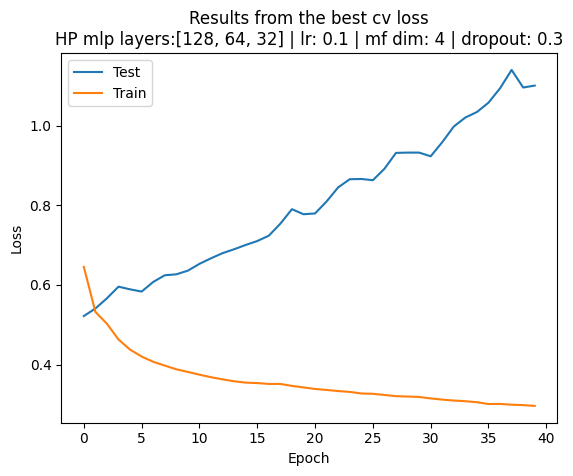

In [12]:
plt.plot(results_df["loss_ep"].loc[4]["test"], label = "Test")
plt.plot(results_df["loss_ep"].loc[4]["train"], label = "Train")
best = results_df.loc[4]
hp_string = f'mlp layers:{best["mlp_layer_sizes"]} | lr: {best["learning_rate"]} | mf dim: {best["mf_dim"]} | dropout: {best["dropout"]}'
plt.title("Results from the best cv loss\nHP " + hp_string)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

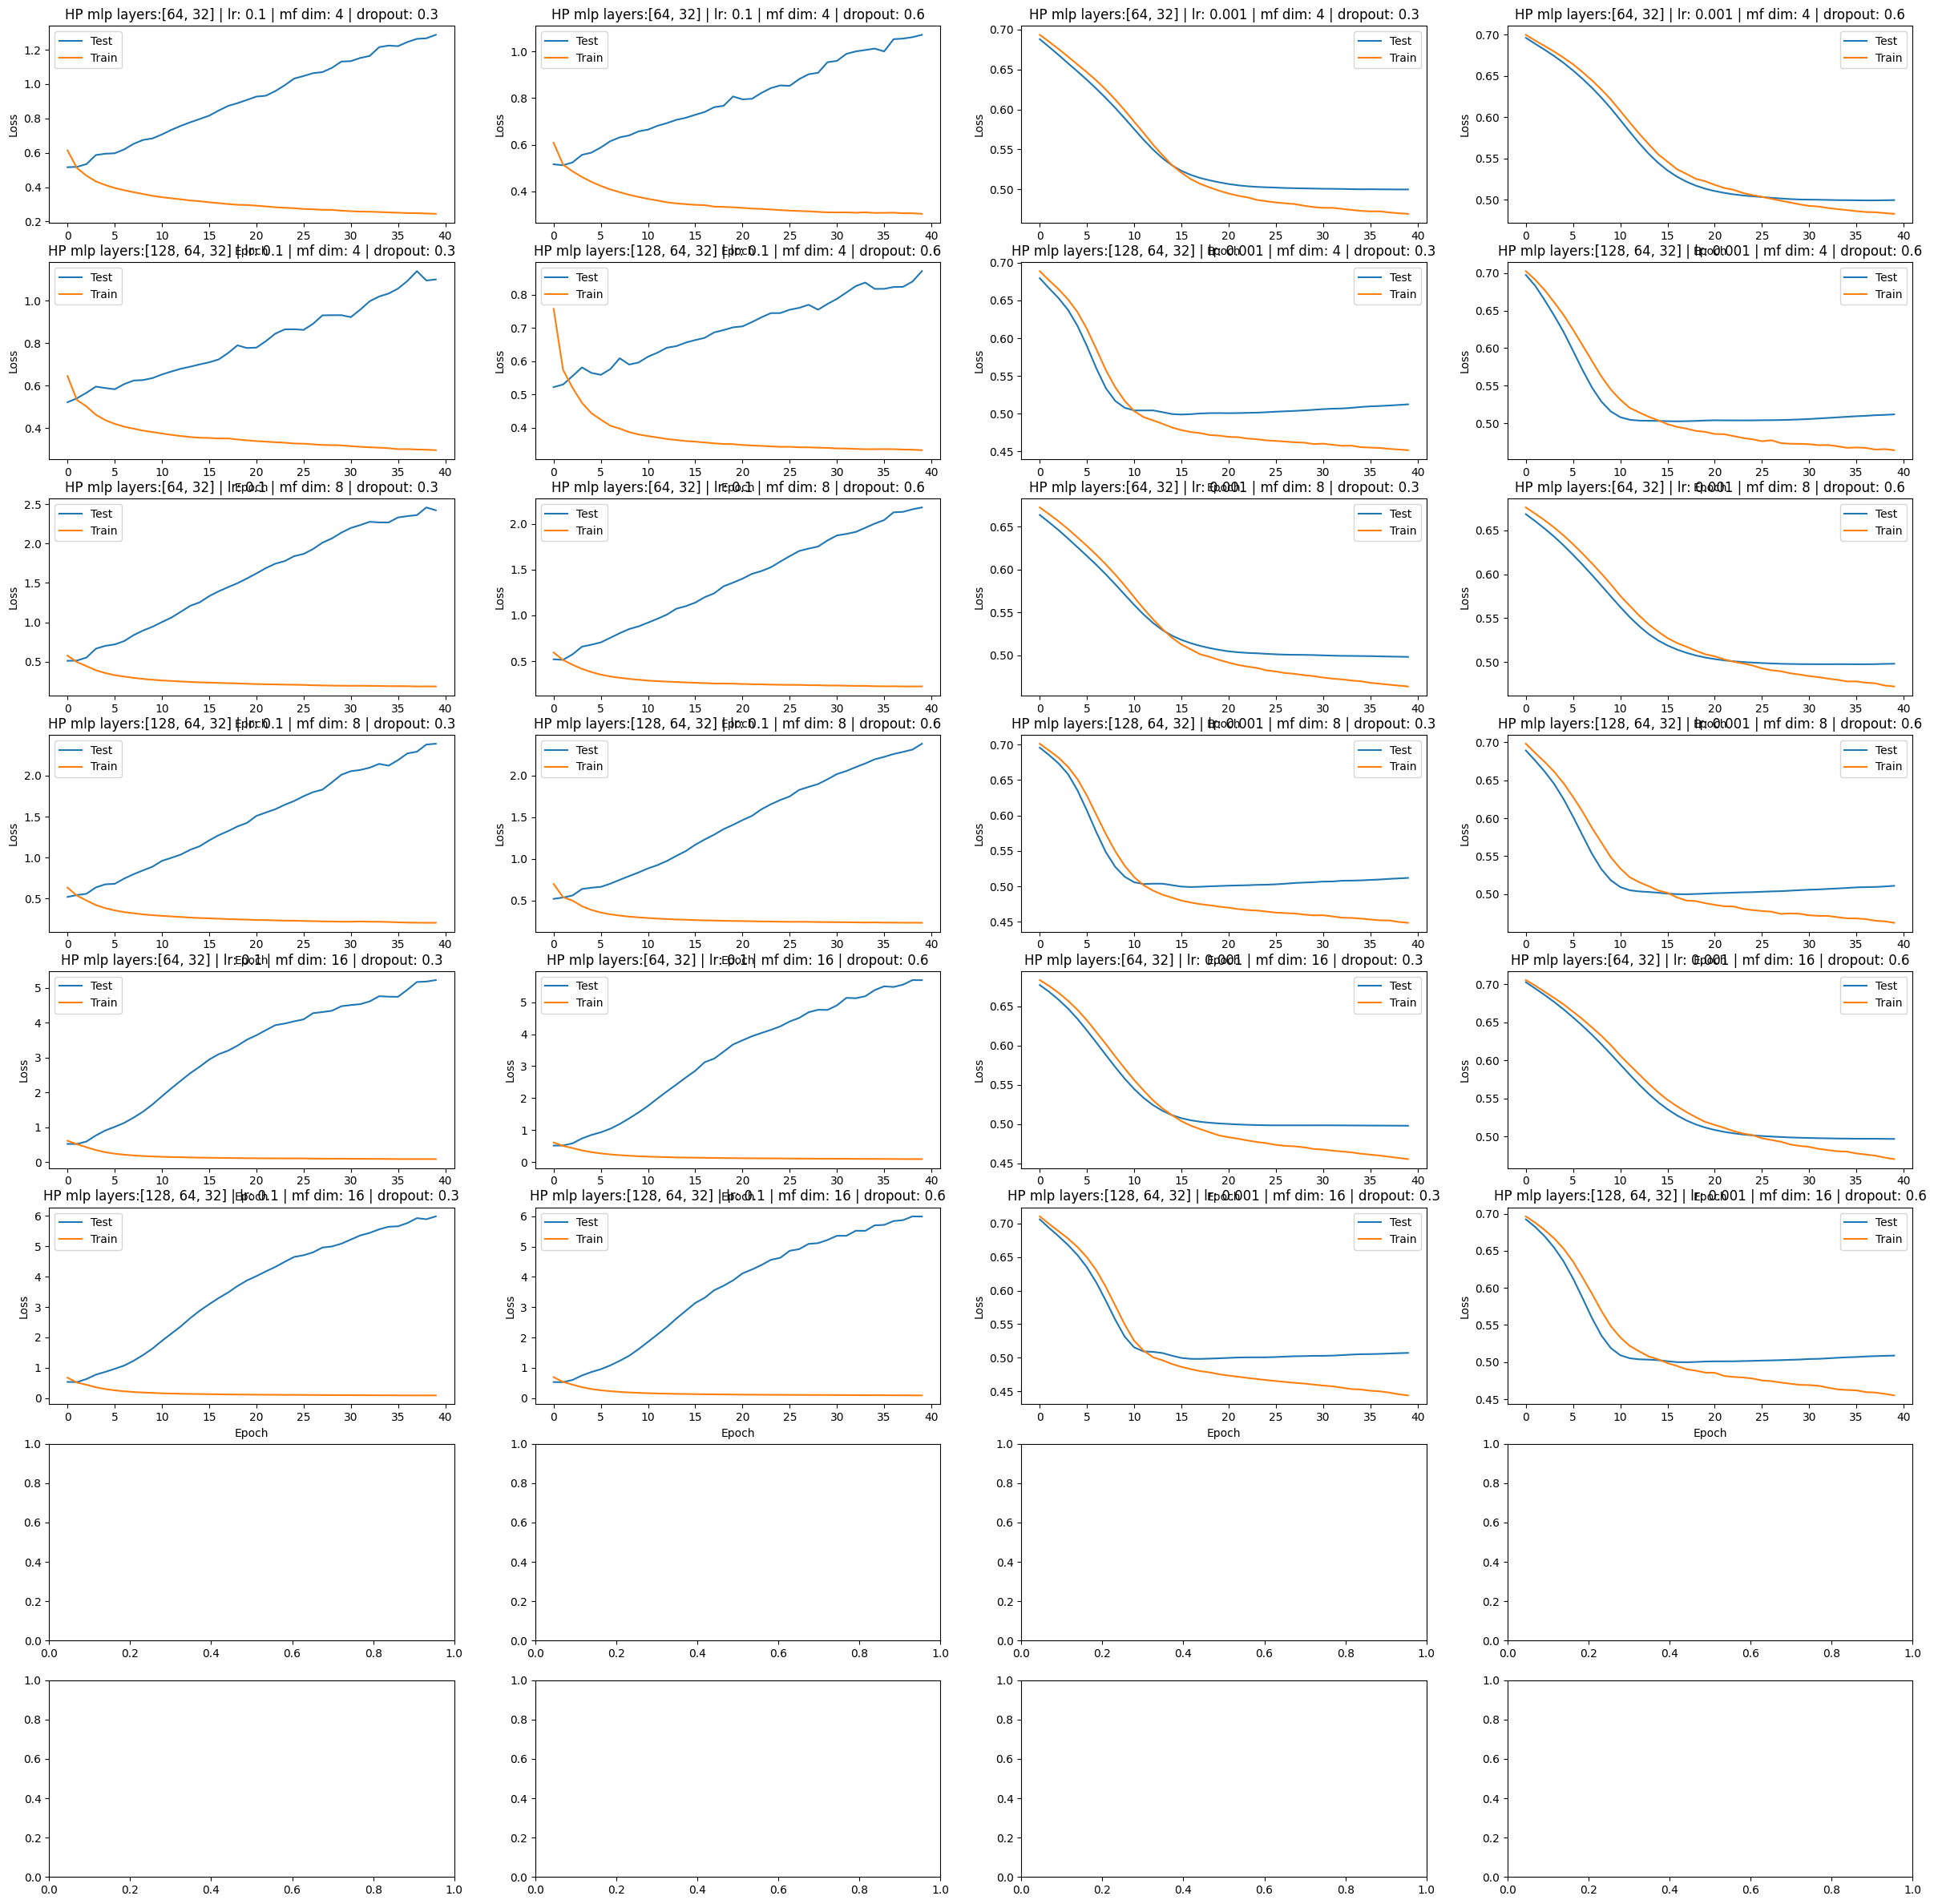

In [13]:
fig, axes = plt.subplots(nrows = 8, ncols = 4, figsize = (30, 30))
axes = axes.flatten()

for i, row in results_df.iterrows():
    axes[i].plot(row["loss_ep"]["test"], label = "Test")
    axes[i].plot(row["loss_ep"]["train"], label = "Train")
    hp_string = f'mlp layers:{row["mlp_layer_sizes"]} | lr: {row["learning_rate"]} | mf dim: {row["mf_dim"]} | dropout: {row["dropout"]}'
    axes[i].title.set_text("HP " + hp_string)
    axes[i].set(xlabel = "Epoch", ylabel = "Loss")
    axes[i].legend()

Better results were achieved with a two-layer perceptron compared to a three-layer one although both showed promising results. 

Signs of overfitting were observed suggesting potential benefits from employing a learning rate adjustment mechanism during training. 

Due to computational limitations an extensive parameter optimization was not conducted.